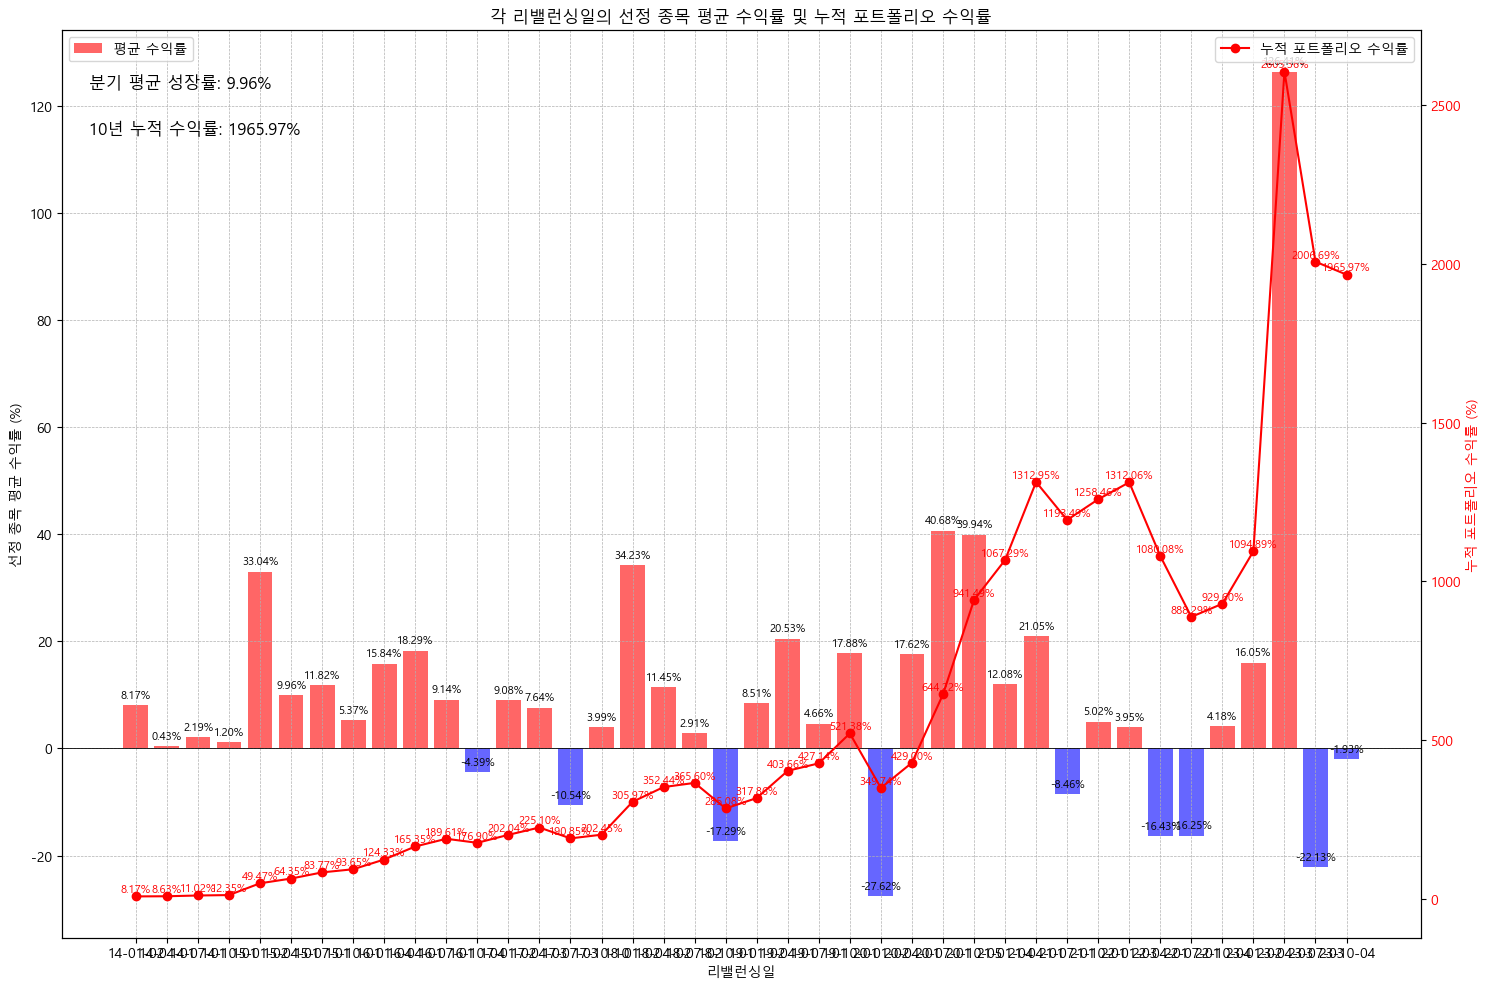

In [53]:
# 최종 코드

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드하기 (예시 경로, 실제 경로로 수정 필요)
close_df = pd.read_csv('reshape_df.csv')

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

# 각 리밸런싱일에 선정된 종목과 그 종목들의 수익률을 저장할 딕셔너리 초기화
held_stocks_dict = {}
stock_returns_dict = {}

# 각 리밸런싱일마다 종목 선정 및 수익률 계산
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    # 해당 기간의 데이터만 추출
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    # 선정된 종목 저장
    held_stocks_dict[date] = selected_stocks
    
    # 선정된 종목의 다음 기간 수익률 계산
    if idx + 1 < len(rebalancing_dates):
        next_date = rebalancing_dates[idx + 1]
    else:
        next_date = close_df['Date'].max()
    
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    
    # 종목별 수익률 저장
    stock_returns_dict[date] = returns


# 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
portfolio_returns = {date: np.mean(returns) * 100 for date, returns in stock_returns_dict.items()}

# 누적 포트폴리오 수익률 계산
cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

# 분기 평균 성장률과 10년 누적 수익률 계산
quarterly_average_growth = np.mean(list(portfolio_returns.values()))
total_cumulative_return = cumulative_portfolio_returns[-1]

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 10))

# 날짜 형식 변환
formatted_dates = [date[2:] for date in portfolio_returns.keys()]

# 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
ax1.set_xlabel('리밸런싱일')
ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.6)

# 막대 위에 수치 표시
for bar, value in zip(bars, portfolio_returns.values()):
    height = bar.get_height()
    ax1.annotate(f'{value:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8, color='black')

# 포트폴리오의 누적 수익률 선그래프로 그리기
ax2 = ax1.twinx()
lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 선 위에 수치 표시
for i, txt in enumerate(cumulative_portfolio_returns):
    ax2.annotate(f'{txt:.2f}%', 
                 (formatted_dates[i], cumulative_portfolio_returns[i]), 
                 textcoords="offset points", 
                 xytext=(0,3), 
                 ha='center', fontsize=8, color='red')

# 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

# 범례 표시
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()


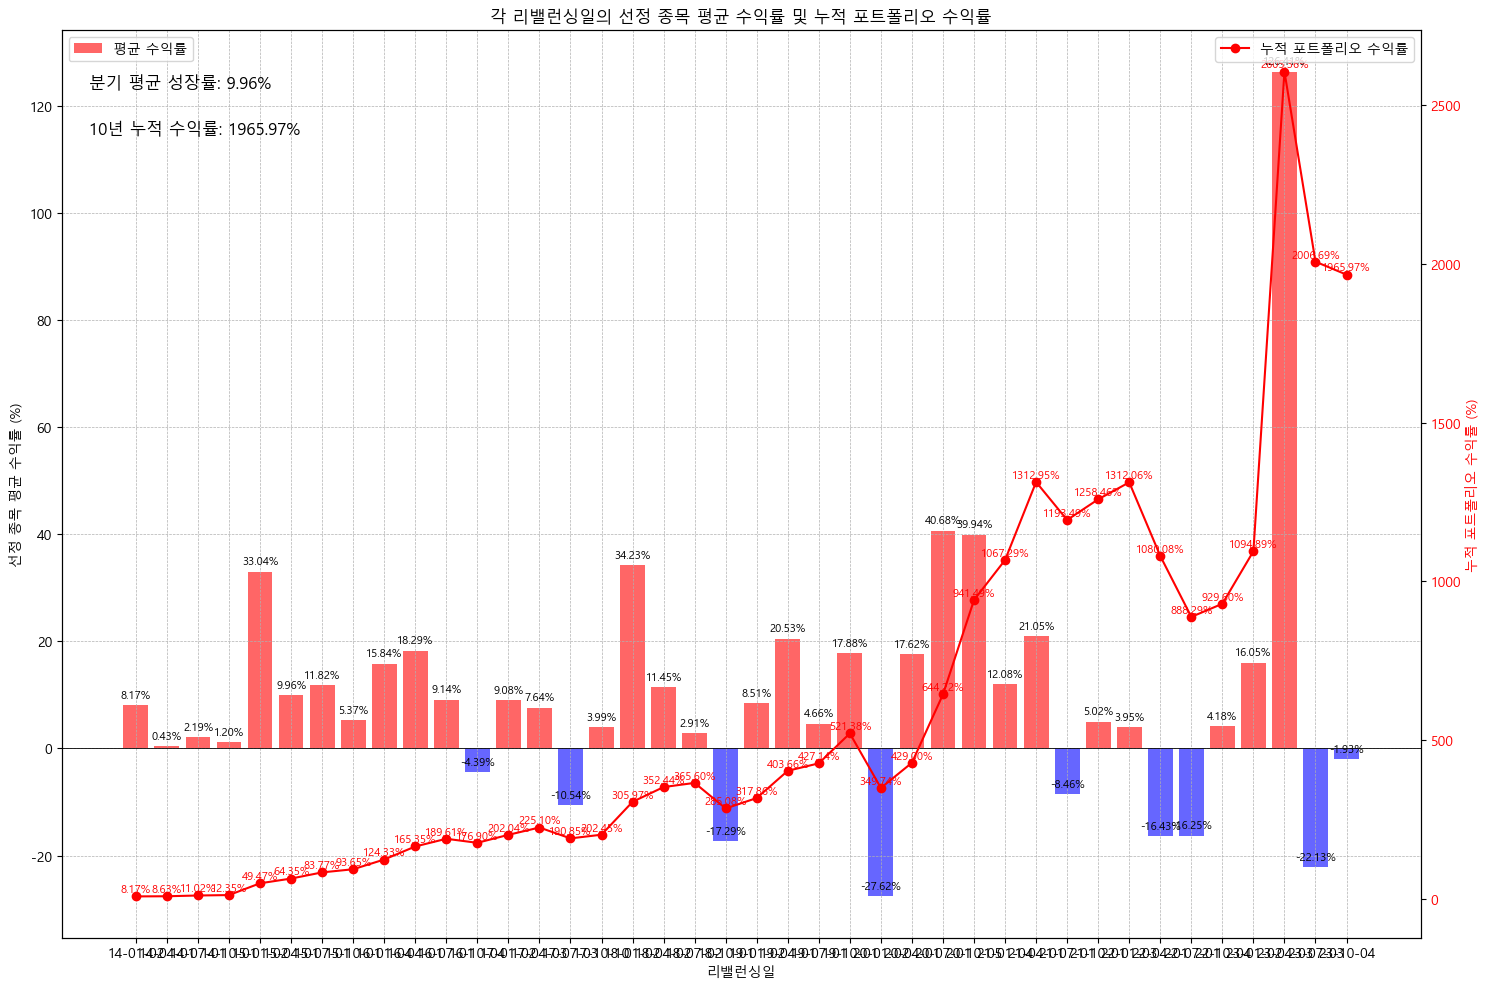

In [58]:
# 함수화

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 전략에 따른 종목 선정 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    held_stocks_dict = {}
    stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < date)].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = rebalancing_dates[idx + 1]
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns
    
    return held_stocks_dict, stock_returns_dict

# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df.csv')

    # 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) * 100 for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 기본 전략을 사용하여 메인 함수 실행
if __name__ == "__main__":
    main(default_strategy)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 주어진 종목 코드의 수익률을 시각화하는 함수
def plot_selected_stock_returns(period_df, start_date, end_date, selected_stocks, company_names_mapping=None):
    # 데이터에 존재하는 종목 코드만 필터링
    existing_stocks = [stock for stock in selected_stocks if stock in period_df.columns]

    # 필터링된 종목만으로 수익률 계산
    returns = (period_df[existing_stocks].iloc[-1] - period_df[existing_stocks].iloc[0]) / period_df[existing_stocks].iloc[0]
    average_return = returns.mean()

    # 시각화
    fig, ax = plt.subplots(figsize=(15, 10))
    # 매핑된 이름 또는 코드를 사용하여 회사명 리스트 생성
    company_names = [company_names_mapping.get(code, code) if company_names_mapping else code for code in existing_stocks]
    # 시각화 코드
    colors = plt.cm.viridis(np.linspace(0.5, 1, len(returns)))
    bars = ax.bar(company_names, returns.values * 100, color=colors, alpha=0.7)
    ax.axhline(average_return * 100, color='red', linestyle='--', linewidth=1.5, label='평균 수익률')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')

    ax.annotate(f'평균 수익률: {average_return * 100:.2f}%',
                xy=(len(company_names)-1, average_return * 100),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=10,
                color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.set_title(f'{start_date}부터 {end_date}까지의 수익률', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(range(len(company_names)))
    ax.set_xticklabels(company_names, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()

# 샘플 데이터로 함수 실행 예시
# 이 부분은 테스트를 위한 것이며, 실제 데이터와 리밸런싱 날짜에 맞게 수정해야 합니다.
# 임의의 데이터를 생성하여 테스트를 진행합니다.

# 임의의 종목 코드 생성
sample_stocks = [str(i) for i in range(100, 110)]

# 임의의 매핑 정보 생성
sample_mapping = {str(i): f'Company {i}' for i in range(100, 110)}  

# 기존 sample_data 데이터프레임에서 날짜 형식을 datetime으로 변환
sample_data['Date'] = pd.to_datetime(sample_data['Date'])

# 테스트를 위한 기간 설정
test_start_date = '2012-10-25'
test_end_date = '2012-10-31'

# 테스트 실행
plot_selected_stock_returns(sample_data, test_start_date, test_end_date, sample_stocks, sample_mapping)


C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stocks, rotation=90)
C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stocks, rotation=90)
C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stocks, rotation=90)
C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stocks, rotation=90)
C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stocks, rotation=90)
C:\Users\성현태\AppData\Local\Temp\ipykernel_20880\4007220685.py:68: UserWarning: FixedF

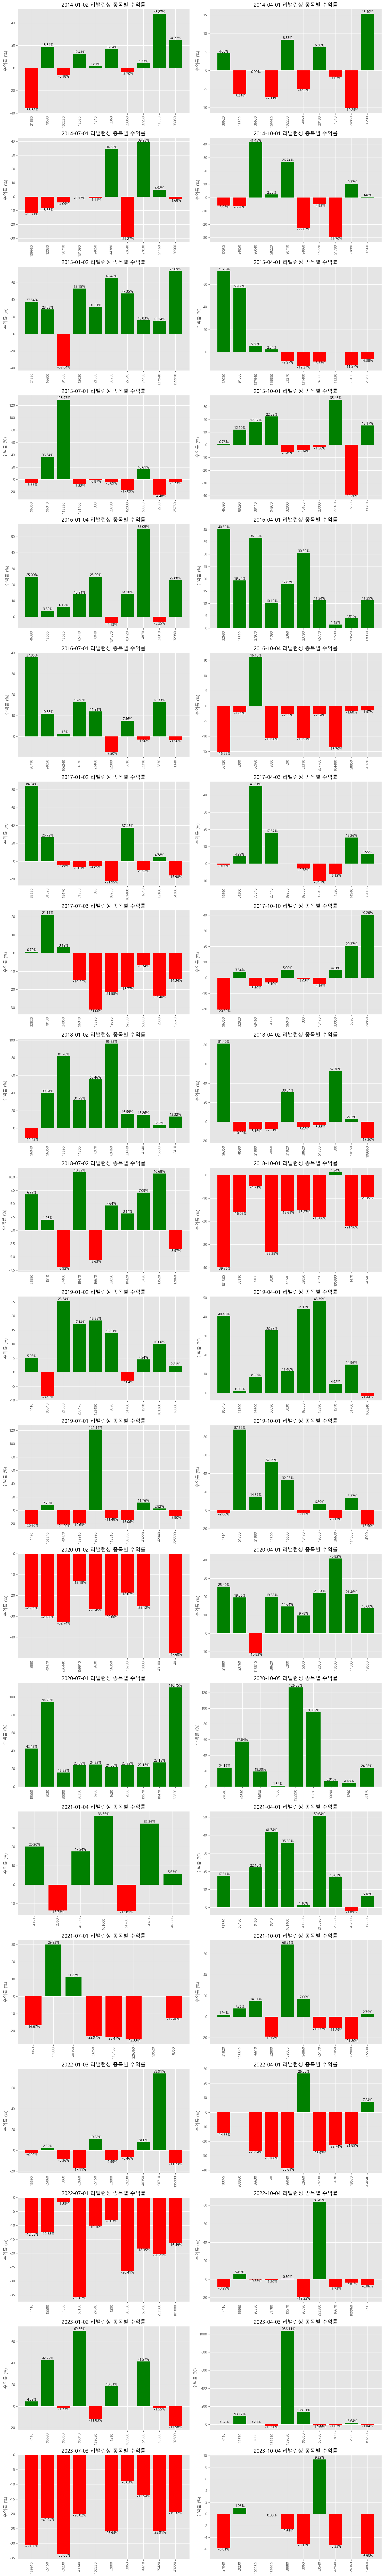

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks_modified(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict

# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        stocks = returns.index
        performance = returns.values
        colors = ['green' if r > 0 else 'red' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        for i, v in enumerate(performance):
            ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')
    
    plt.tight_layout()
    plt.show()

# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function, close_df_path, rebalancing_dates):
    # 데이터 로드
    close_df = pd.read_csv(close_df_path)
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks_modified(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)

# 사용 예
main(default_strategy, 'reshape_df.csv', ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04'])


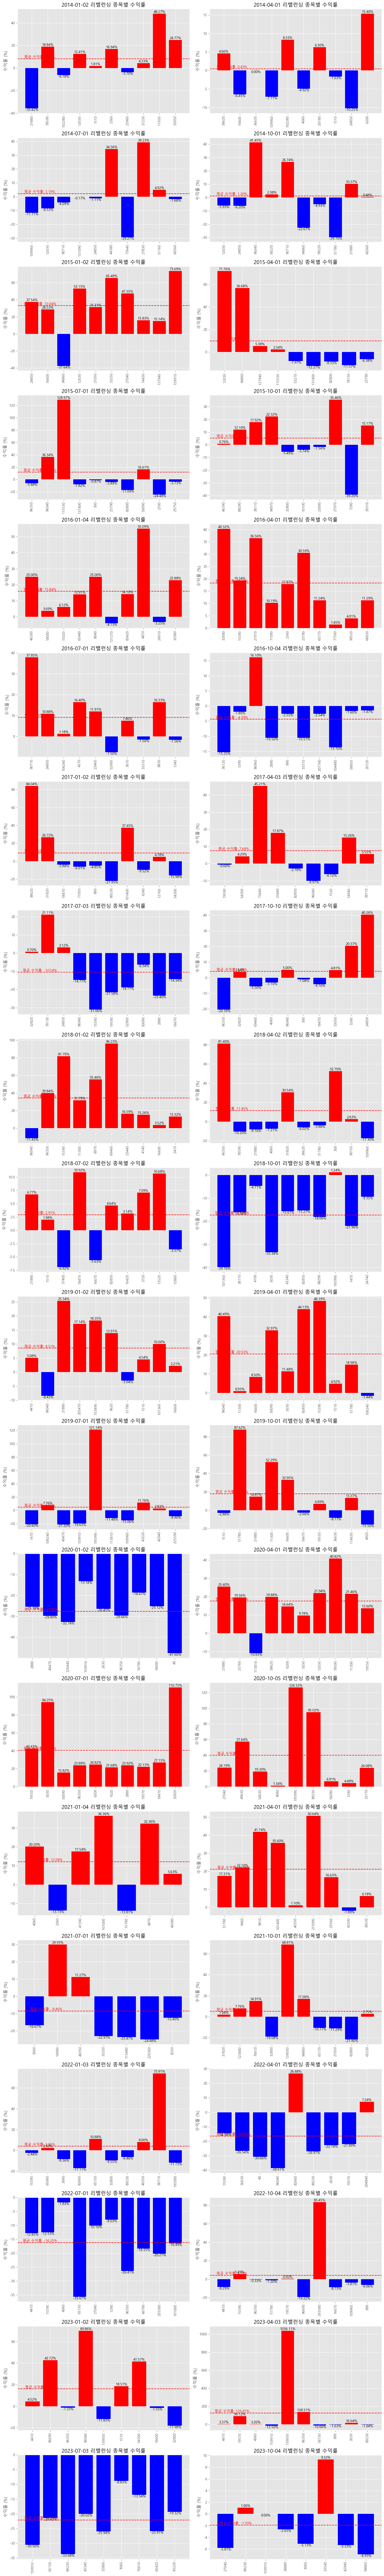

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks_modified(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict

# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function, close_df_path, rebalancing_dates):
    # 데이터 로드
    close_df = pd.read_csv(close_df_path)
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks_modified(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)

# 사용 예
main(default_strategy, 'reshape_df.csv', ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04'])


In [68]:
import yfinance as yf
data = yf.download('139050.KQ')

[*********************100%***********************]  1 of 1 completed


In [73]:
print(data)

               Open     High      Low    Close     Adj Close  Volume
Date                                                                
2011-07-29  54500.0  60000.0  46500.0  46500.0  46453.218750  665054
2011-08-01  42800.0  43300.0  40450.0  41800.0  41757.949219  526900
2011-08-02  42150.0  43450.0  39800.0  40400.0  40359.355469  296481
2011-08-03  40150.0  40750.0  37750.0  38500.0  38461.269531  146402
2011-08-04  39250.0  40150.0  35750.0  35750.0  35714.035156  176495
...             ...      ...      ...      ...           ...     ...
2023-10-30   5770.0   6290.0   5770.0   6130.0   6130.000000   24873
2023-10-31   6170.0   6340.0   6170.0   6240.0   6240.000000   10366
2023-11-01   6150.0   6630.0   6110.0   6630.0   6630.000000   28199
2023-11-02   6630.0   6720.0   6460.0   6630.0   6630.000000   19694
2023-11-03   6630.0   6630.0   6490.0   6610.0   6610.000000   22953

[2993 rows x 6 columns]


In [55]:
from pykrx import stock 2585 1038 1547 

def get_company_names_from_pykrx(stock_codes):
    company_names_mapping = {}
    for code in stock_codes:
        # get_market_ticker_name 함수가 문자열을 반환하도록 보장
        company_name = stock.get_market_ticker_name(code)
        # 반환된 company_name이 문자열이라면, 딕셔너리에 추가
        if isinstance(company_name, str):
            company_names_mapping[code] = company_name
    return company_names_mapping

# held_stocks_dict에서 종목코드 리스트를 생성
stock_codes = list(set([code for sublist in held_stocks_dict.values() for code in sublist]))  # 중복 제거를 위해 set 사용

company_names = get_company_names_from_pykrx(stock_codes)
print(company_names)


{'137940': '넥스트아이', '204840': '지엘팜텍', '115480': '씨유메디칼', '293580': '나우IB', '106240': '파인테크닉스', '104480': '티케이케미칼', '139050': '시티랩스', '101000': '상상인인더스트리', '101360': '에코앤드림', '225590': '패션플랫폼', '131370': '알서포트', '115530': '씨엔플러스', '123840': '한일진공', '159910': '스킨앤스킨', '153490': '우리이앤엘', '114630': '폴라리스우노', '207760': '미스터블루', '102280': '쌍방울', '109960': '에이프로젠 H&G', '101400': '엔시트론', '195990': '에이비프로바이오', '113810': '디젠스', '205470': '휴마시스', '226440': '한송네오텍', '226360': 'KH 건설', '215090': '휴센텍', '131400': '이브이첨단소재', '131090': '시큐브', '208860': '엔지스테크널러지'}


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:2331: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(self.convert_xunits(x))


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 2 with shape (0, 0).

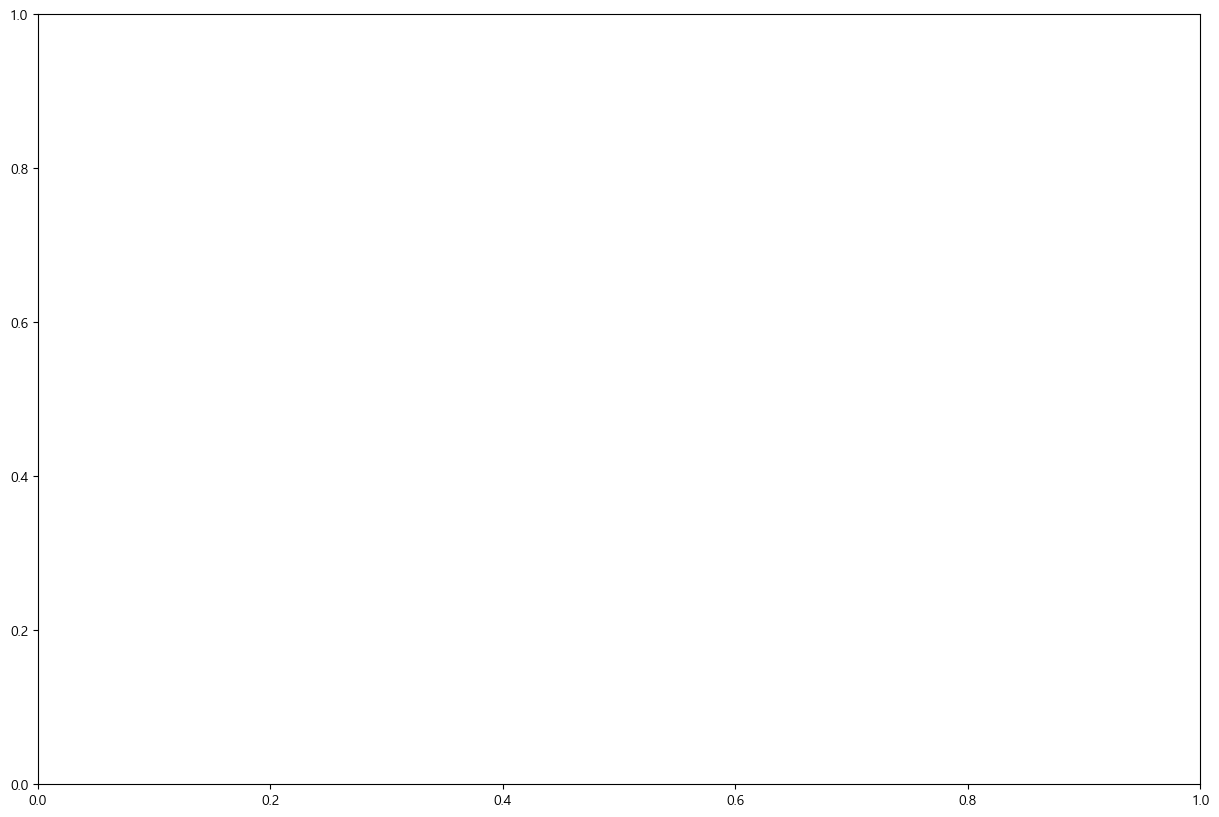

In [56]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from pykrx import stock

# # 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

# # 데이터 로드
# close_df = pd.read_csv('reshape_df.csv')  # 실제 사용시 주석을 제거하세요.

# # 리밸런싱일 정의하기
# rebalancing_dates = ['2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
#                     '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
#                     '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
#                     '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
#                     '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
#                     '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
#                     '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
#                     '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
#                     '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
#                     '2023-04-03', '2023-07-03', '2023-10-04']

# def format_stock_code(code):
#     # 종목 코드를 6자리 포맷으로 변환하는 함수
#     return str(code).zfill(6)

# # 전략에 따른 종목 선정 함수
# def select_stocks(close_df, rebalancing_dates):
#     held_stocks_dict = {}
#     for idx, date in enumerate(rebalancing_dates):
#         # 해당 기간의 데이터 추출
#         start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
#         end_date = pd.to_datetime(date)
#         period_df = close_df.loc[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

#         # 가격이 30% 이상 하락한 종목 찾기
#         price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
#         dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()

#         # 해당 종목들의 변동성 계산
#         volatility = period_df[dropped_stocks].iloc[-60:].std()

#         # 변동성이 낮은 종목 10개 선정
#         selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()

#         # 포맷된 종목 코드 저장
#         held_stocks_dict[date] = [format_stock_code(code) for code in selected_stocks]
    
#     return held_stocks_dict

# held_stocks_dict = select_stocks(close_df, rebalancing_dates)


# 종목 코드로부터 회사 이름 매핑
def get_company_names_from_pykrx(stock_codes):
    company_names_mapping = {}
    for code in stock_codes:
        try:
            company_name = stock.get_market_ticker_name(code)
            company_names_mapping[code] = company_name
        except:
            # 매핑 실패 시, 종목 코드 그대로 사용
            company_names_mapping[code] = code
    return company_names_mapping

stock_codes = list(set(code for sublist in held_stocks_dict.values() for code in sublist))
company_names_mapping = get_company_names_from_pykrx(stock_codes)

def plot_selected_stock_returns(start_date, end_date, selected_stocks, company_names_mapping):
    # 주어진 종목 코드의 수익률을 시각화하는 함수
    # 데이터프레임에서 해당 날짜 범위를 추출
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)]

    # 데이터에 존재하는 종목 코드만 필터링
    existing_stocks = [stock for stock in selected_stocks if stock in period_df.columns]

    # 필터링된 종목만으로 수익률 계산
    returns = (period_df[existing_stocks].iloc[-1] - period_df[existing_stocks].iloc[0]) / period_df[existing_stocks].iloc[0]
    average_return = returns.mean()

    # 시각화
    fig, ax = plt.subplots(figsize=(15, 10))
    # 매핑된 이름 또는 코드를 사용하여 회사명 리스트 생성
    company_names = [company_names_mapping.get(code, code) for code in existing_stocks]
    # ... 나머지 시각화 코드
    colors = plt.cm.Blues(np.linspace(0.5, 1, len(returns)))
    bars = ax.bar(company_names, returns.values * 100, color=colors, alpha=0.7)
    ax.axhline(average_return * 100, color='red', linestyle='--', linewidth=1.5, label='평균 수익률')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')
    ax.annotate(f'평균 수익률: {average_return * 100:.2f}%',
                xy=(len(company_names)-1, average_return * 100),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=10,
                color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.set_title(f'Alpha-investing Strategy A: {start_date}부터 {end_date}까지의 수익률', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(company_names)
    ax.set_xticklabels(company_names, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()




for date in rebalancing_dates[:-1]:
    next_date = rebalancing_dates[rebalancing_dates.index(date) + 1]
    selected_stocks = held_stocks_dict[date]
    plot_selected_stock_returns(date, next_date, selected_stocks, company_names_mapping)


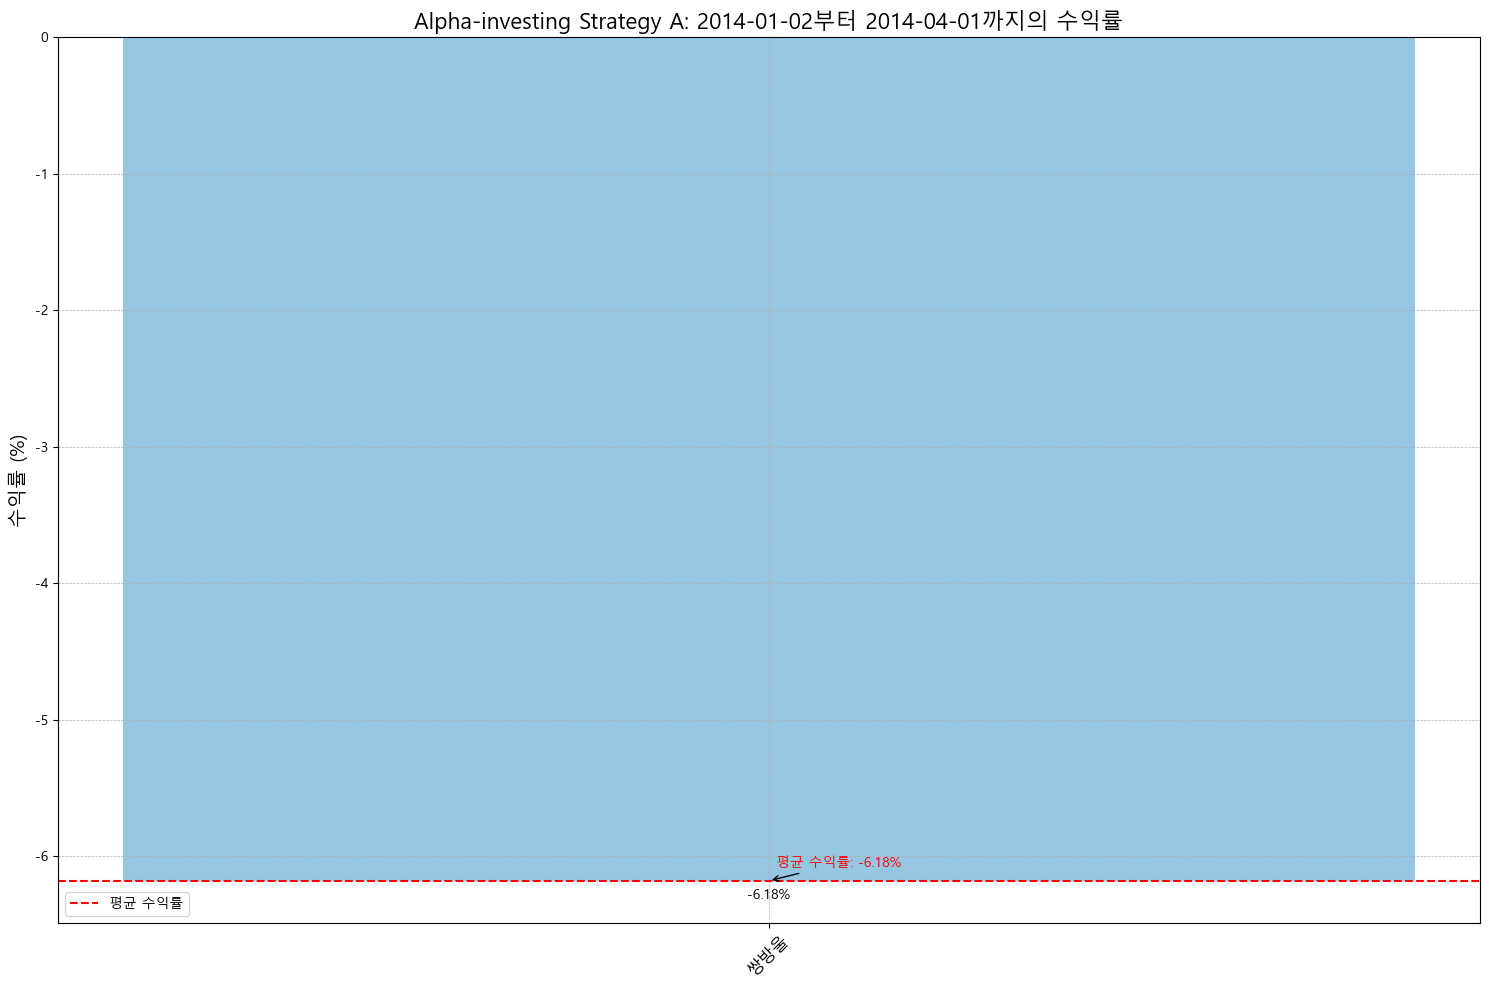

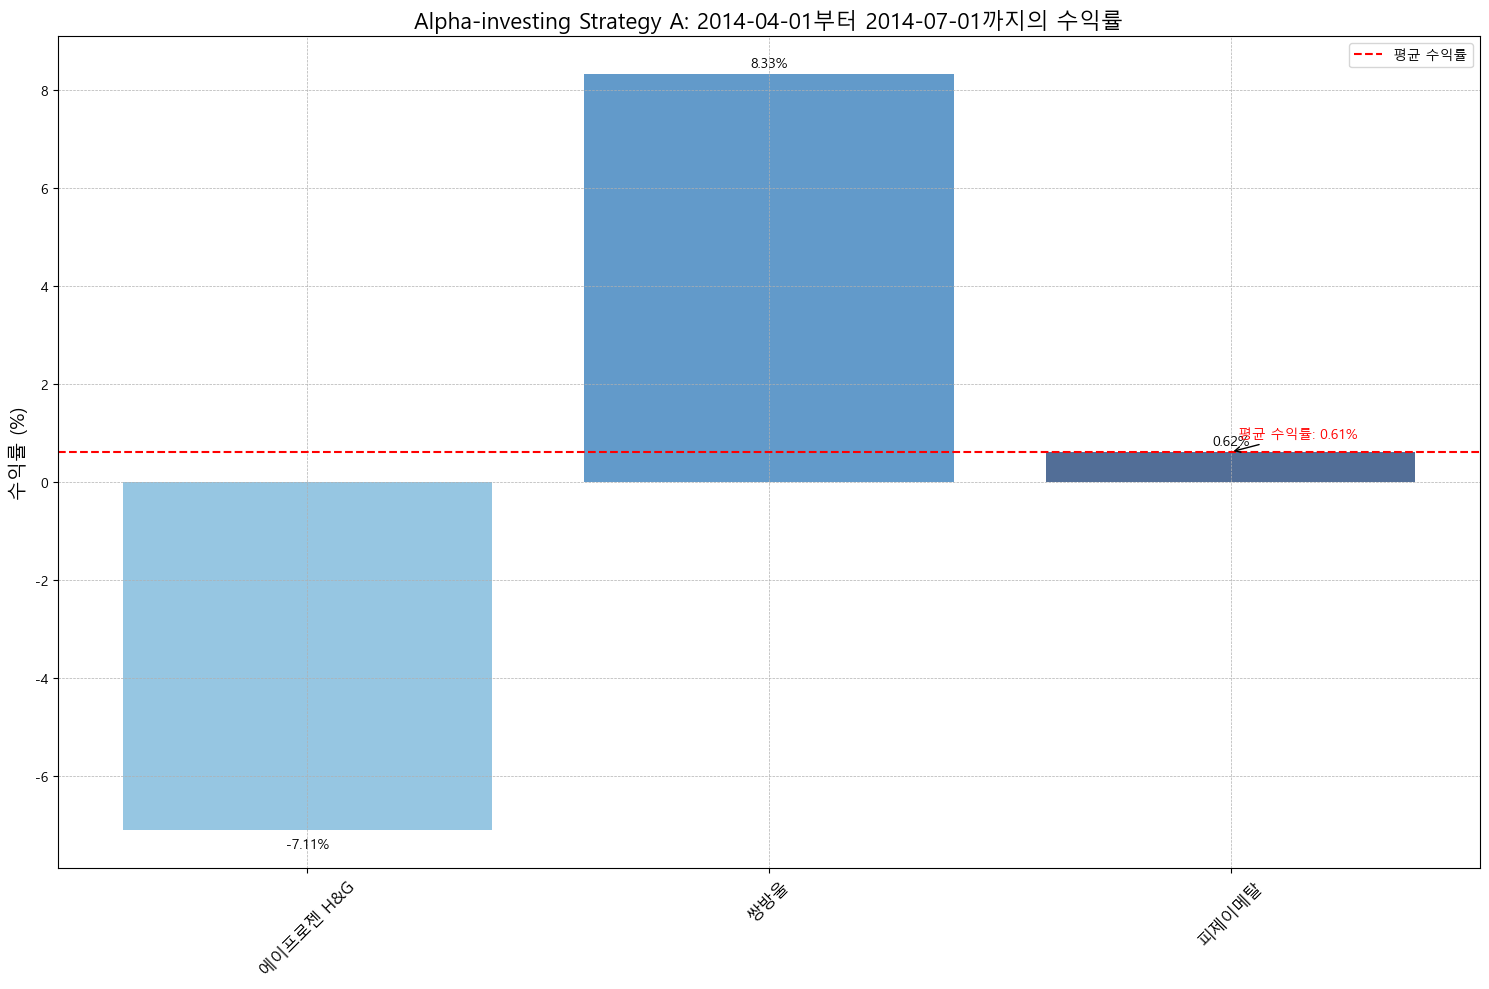

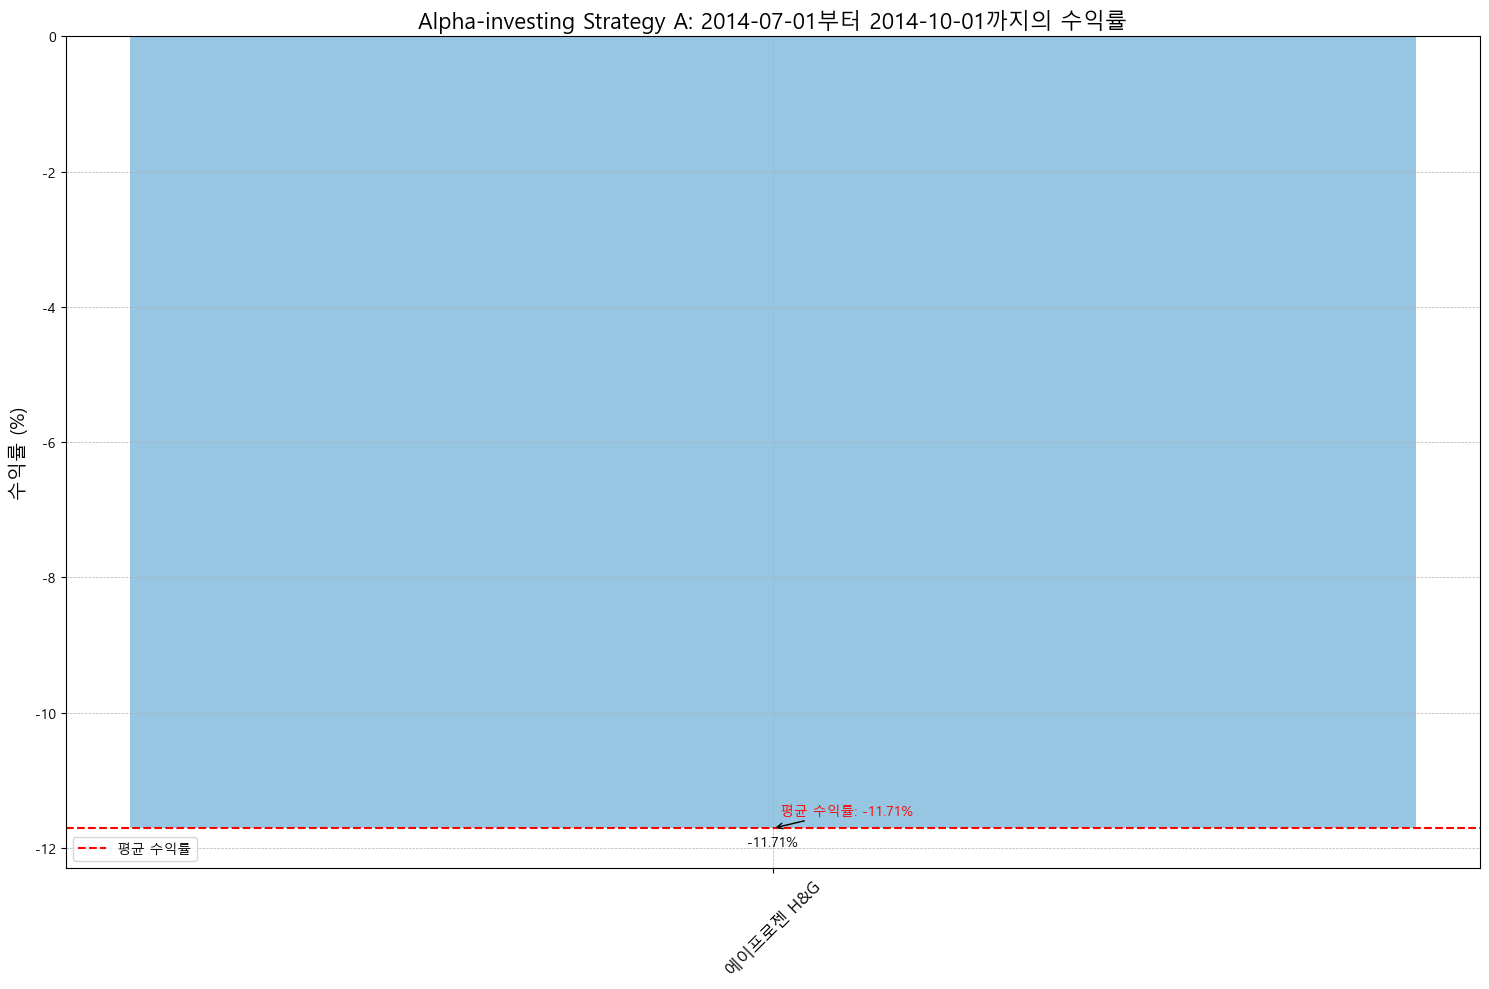

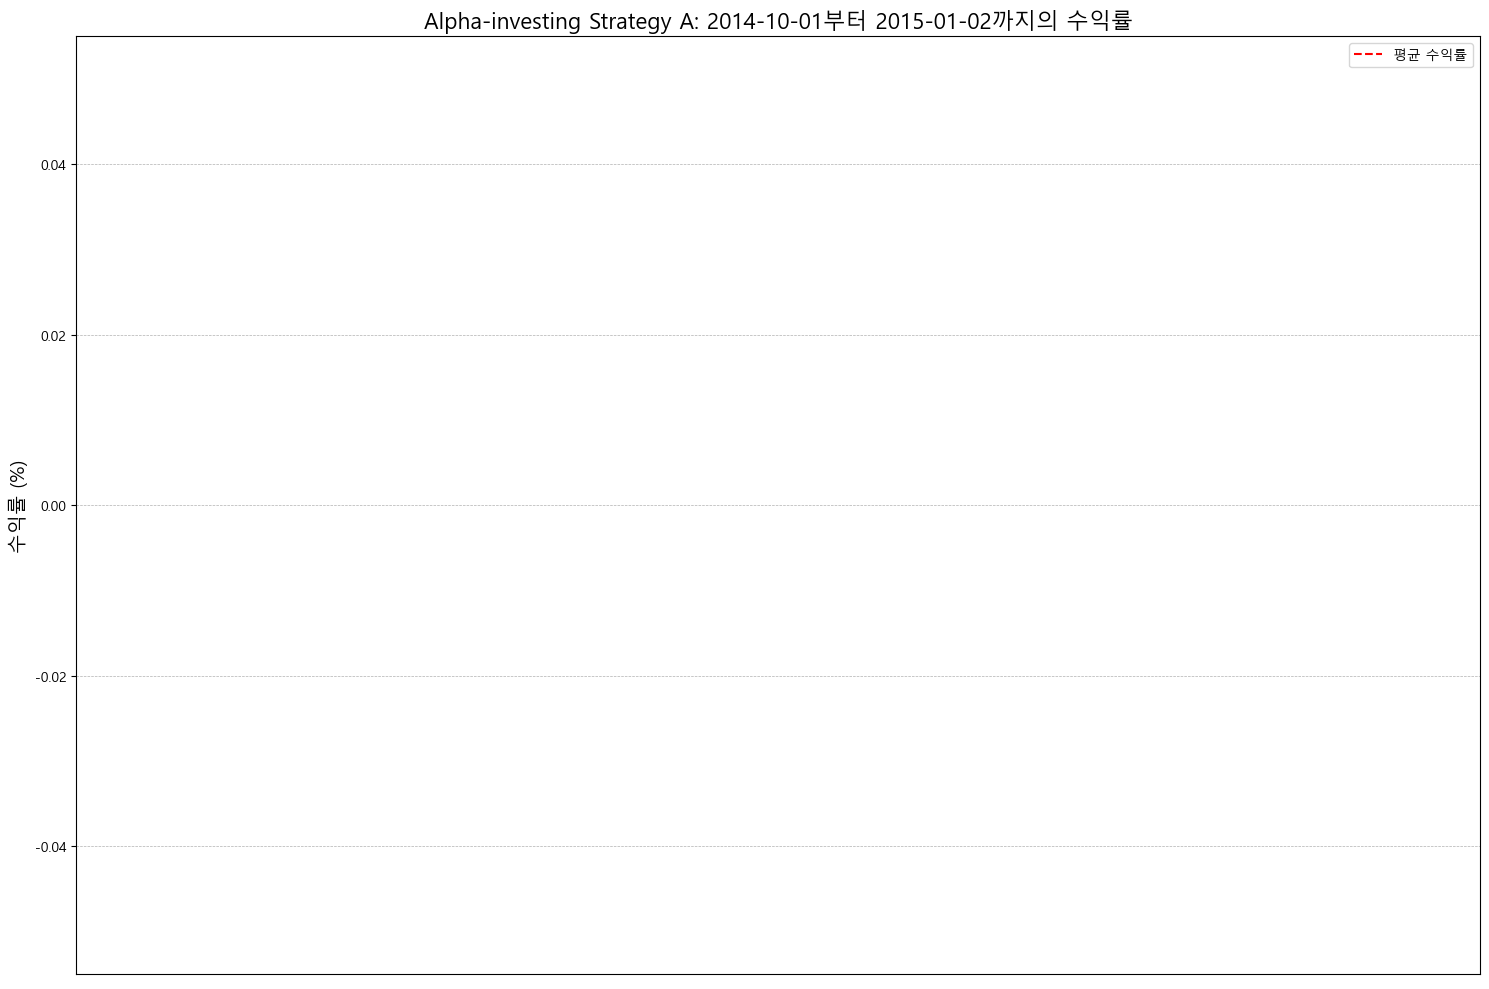

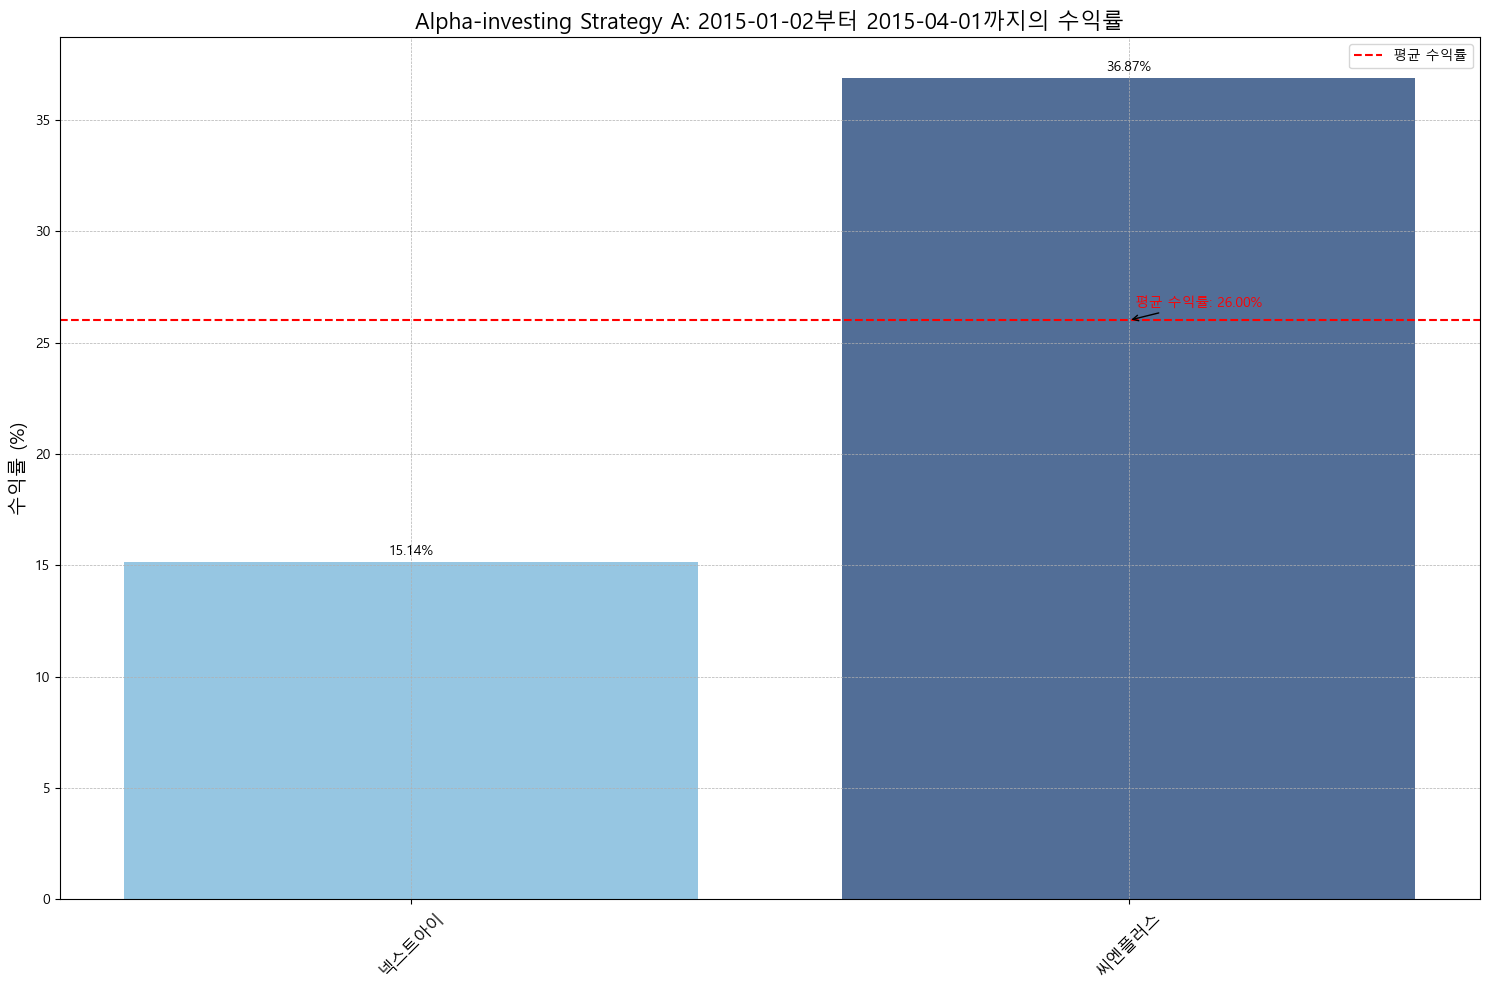

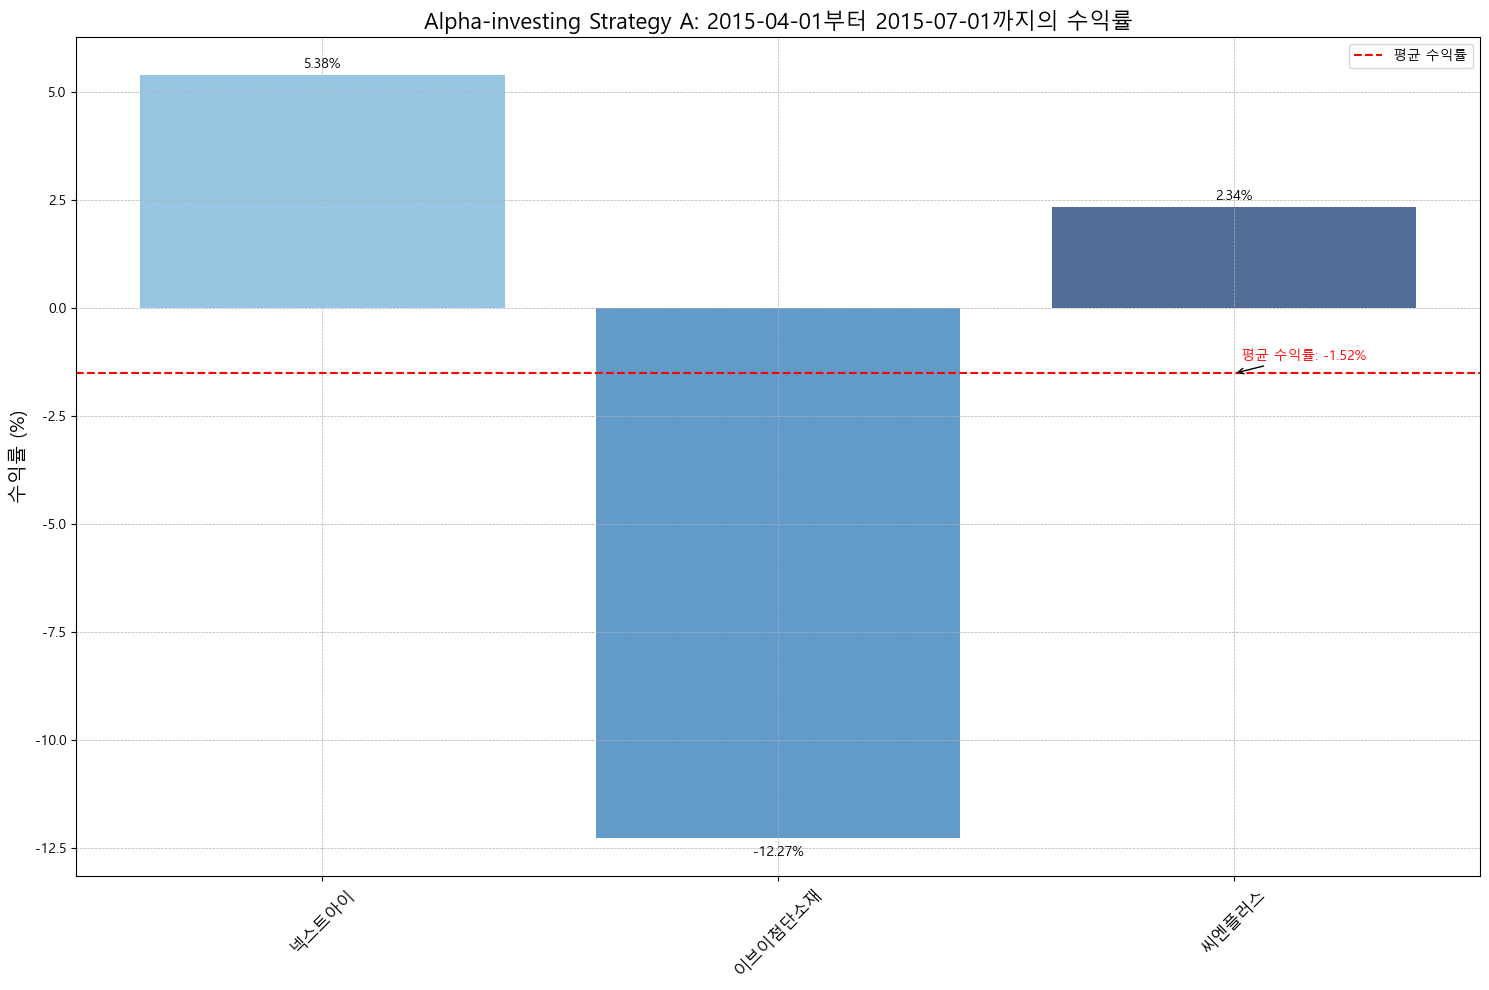

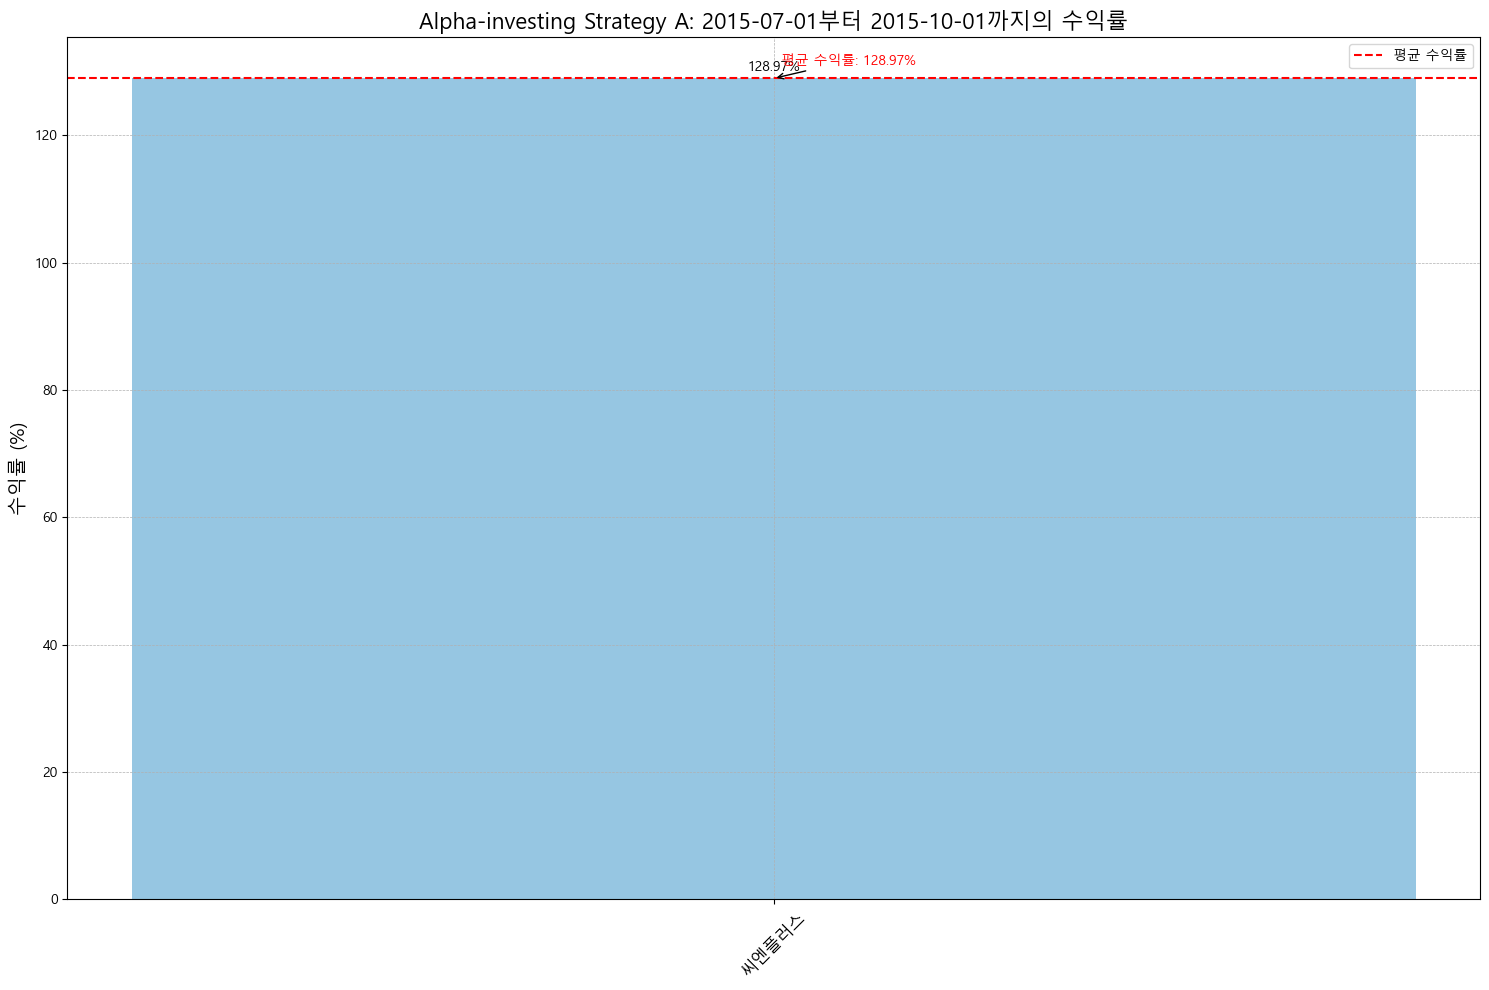

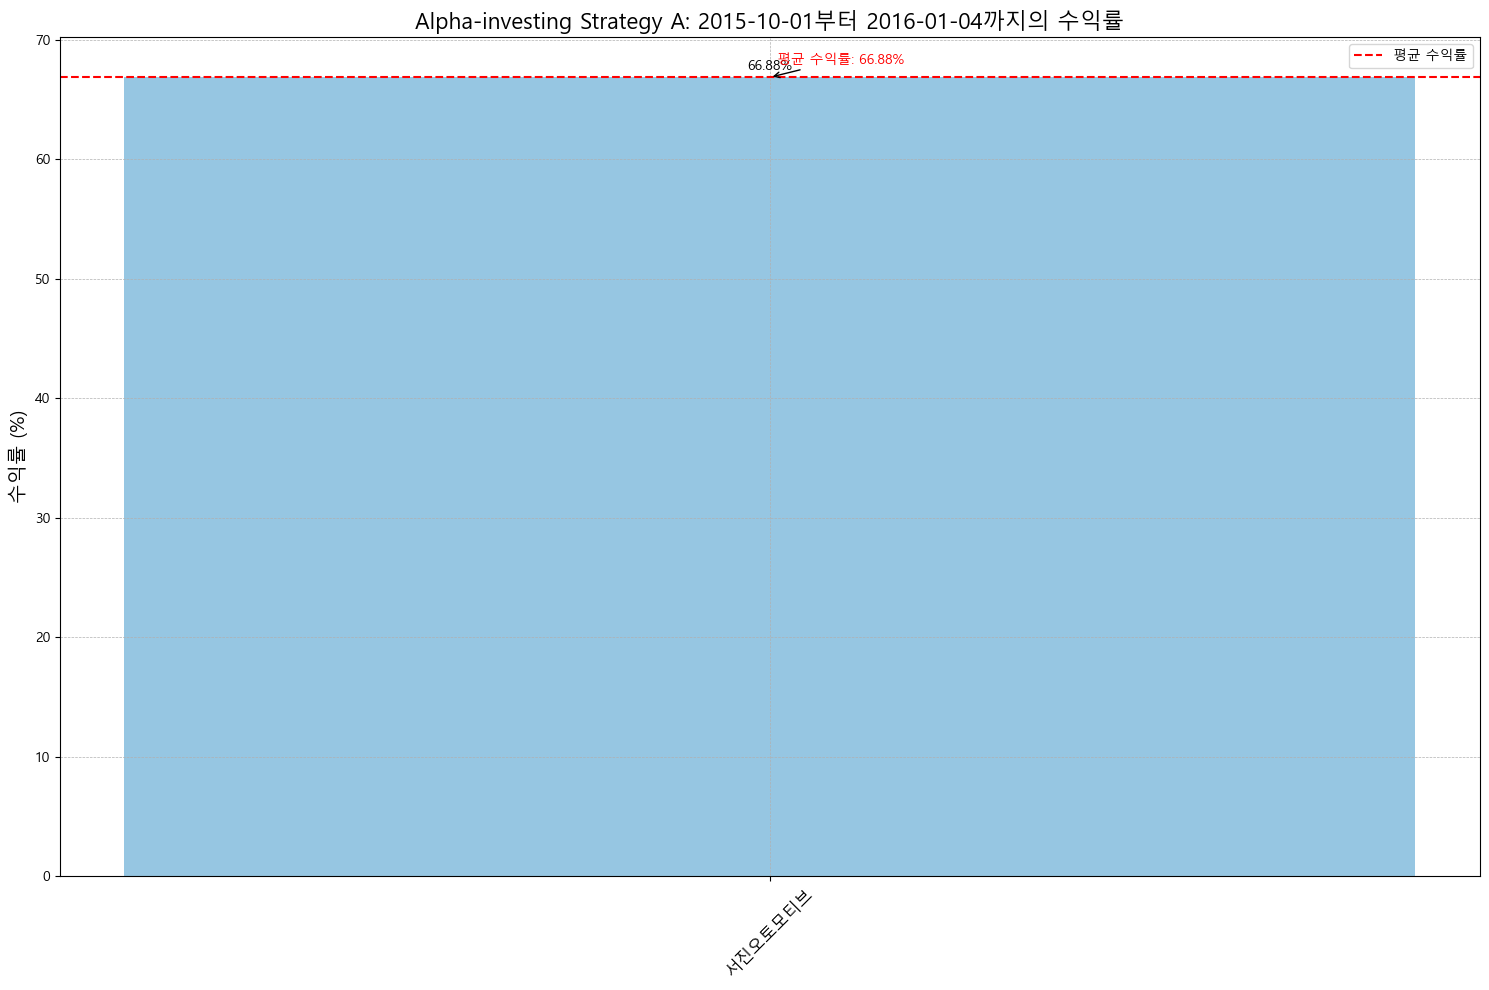

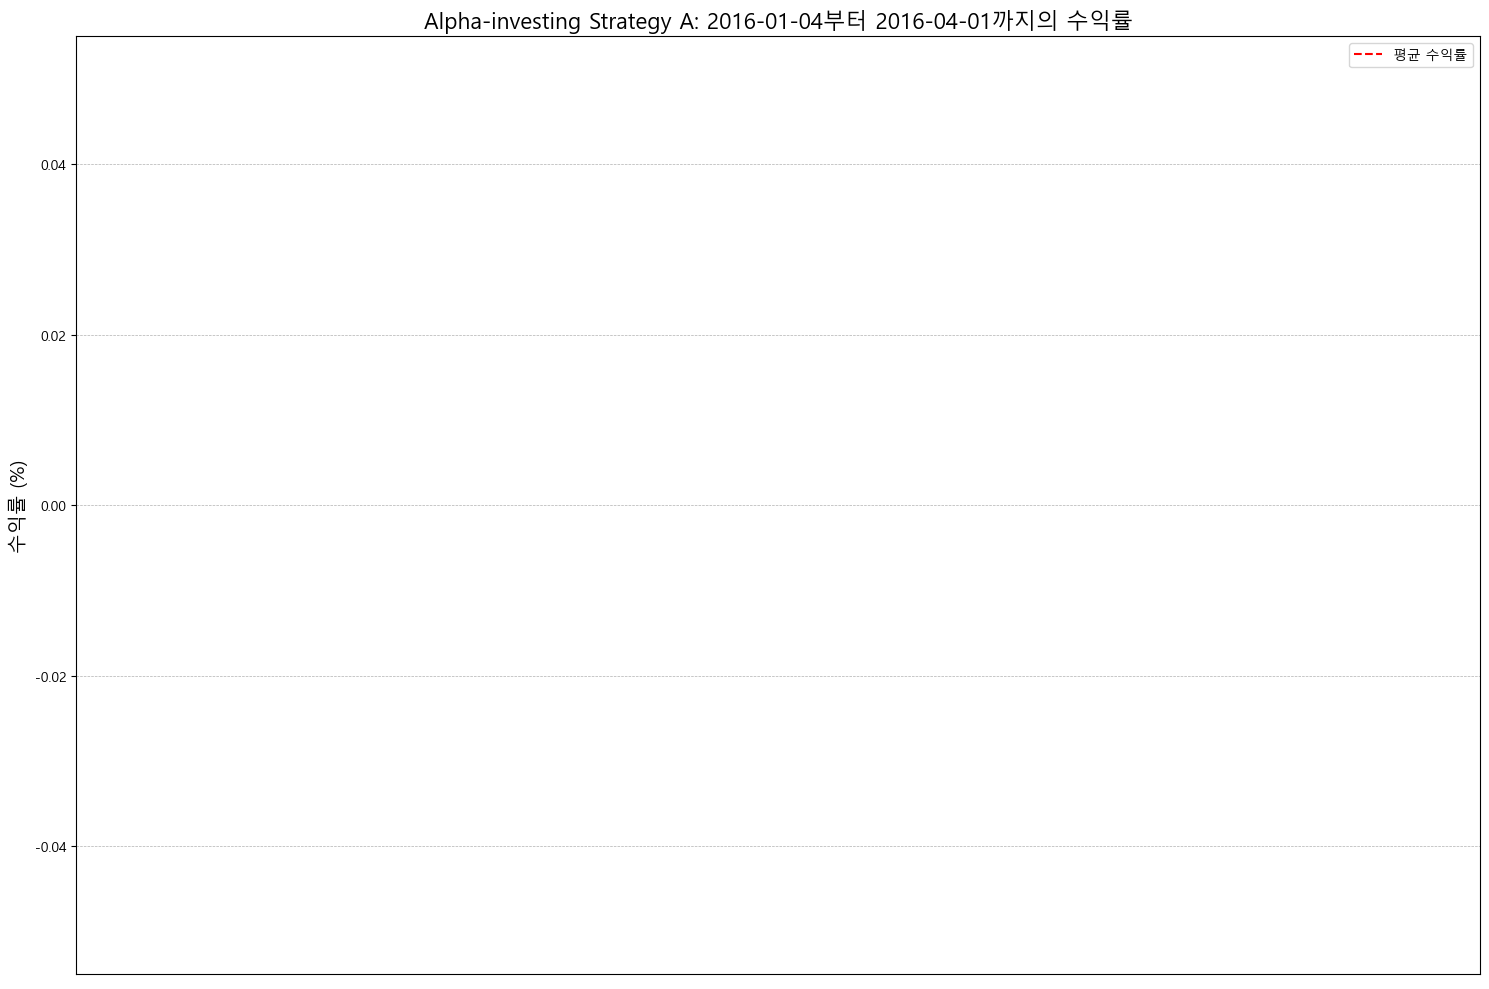

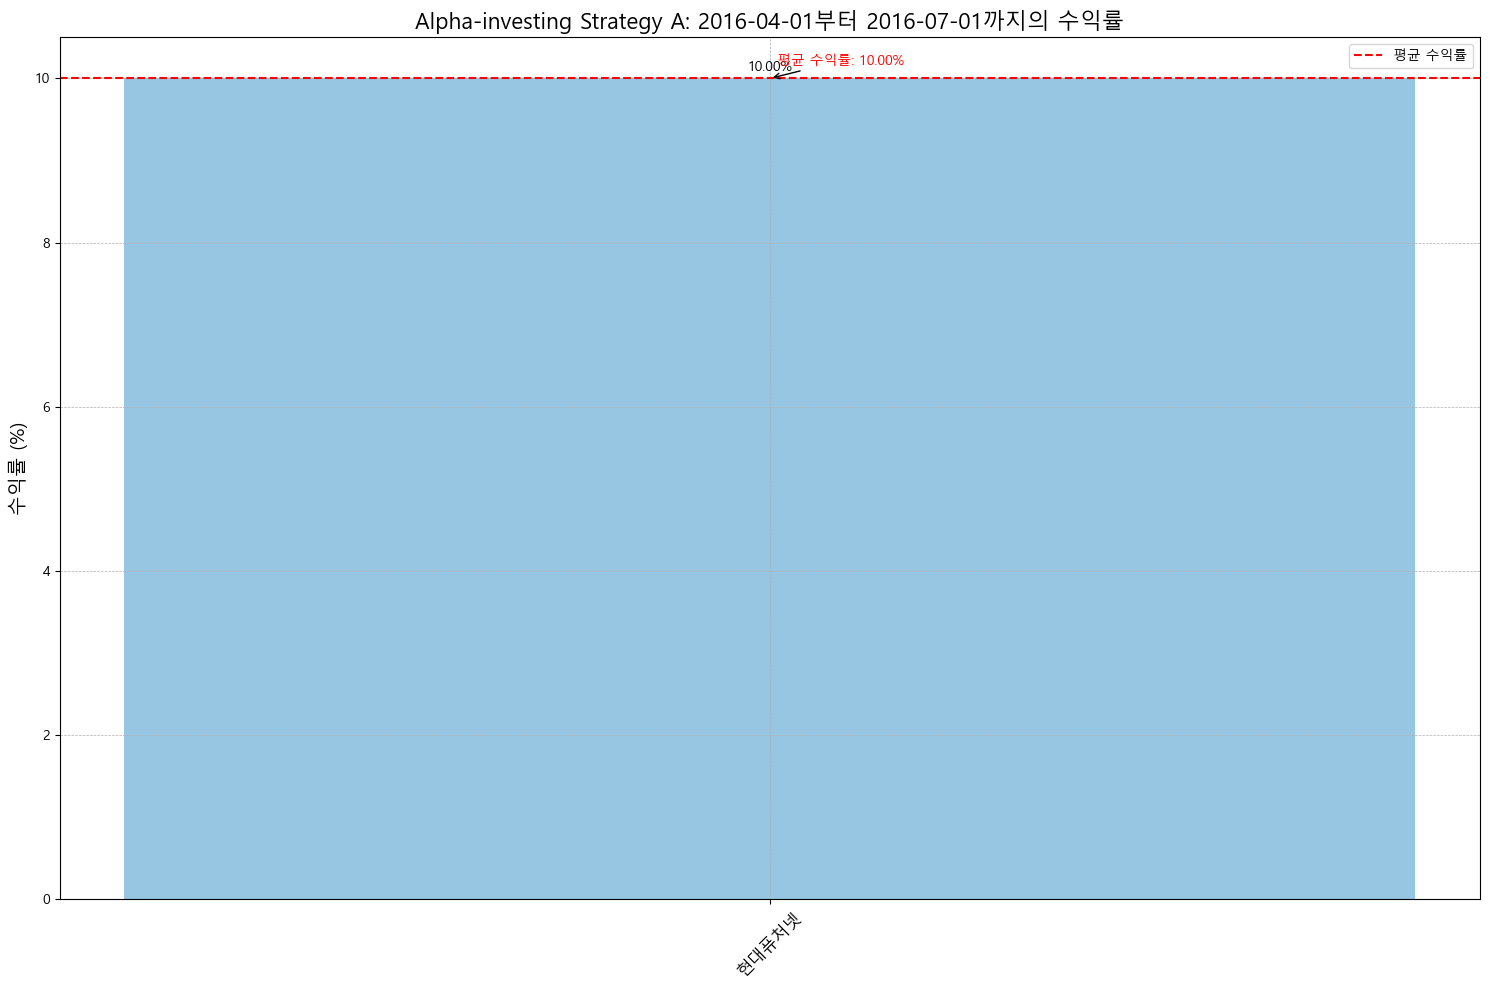

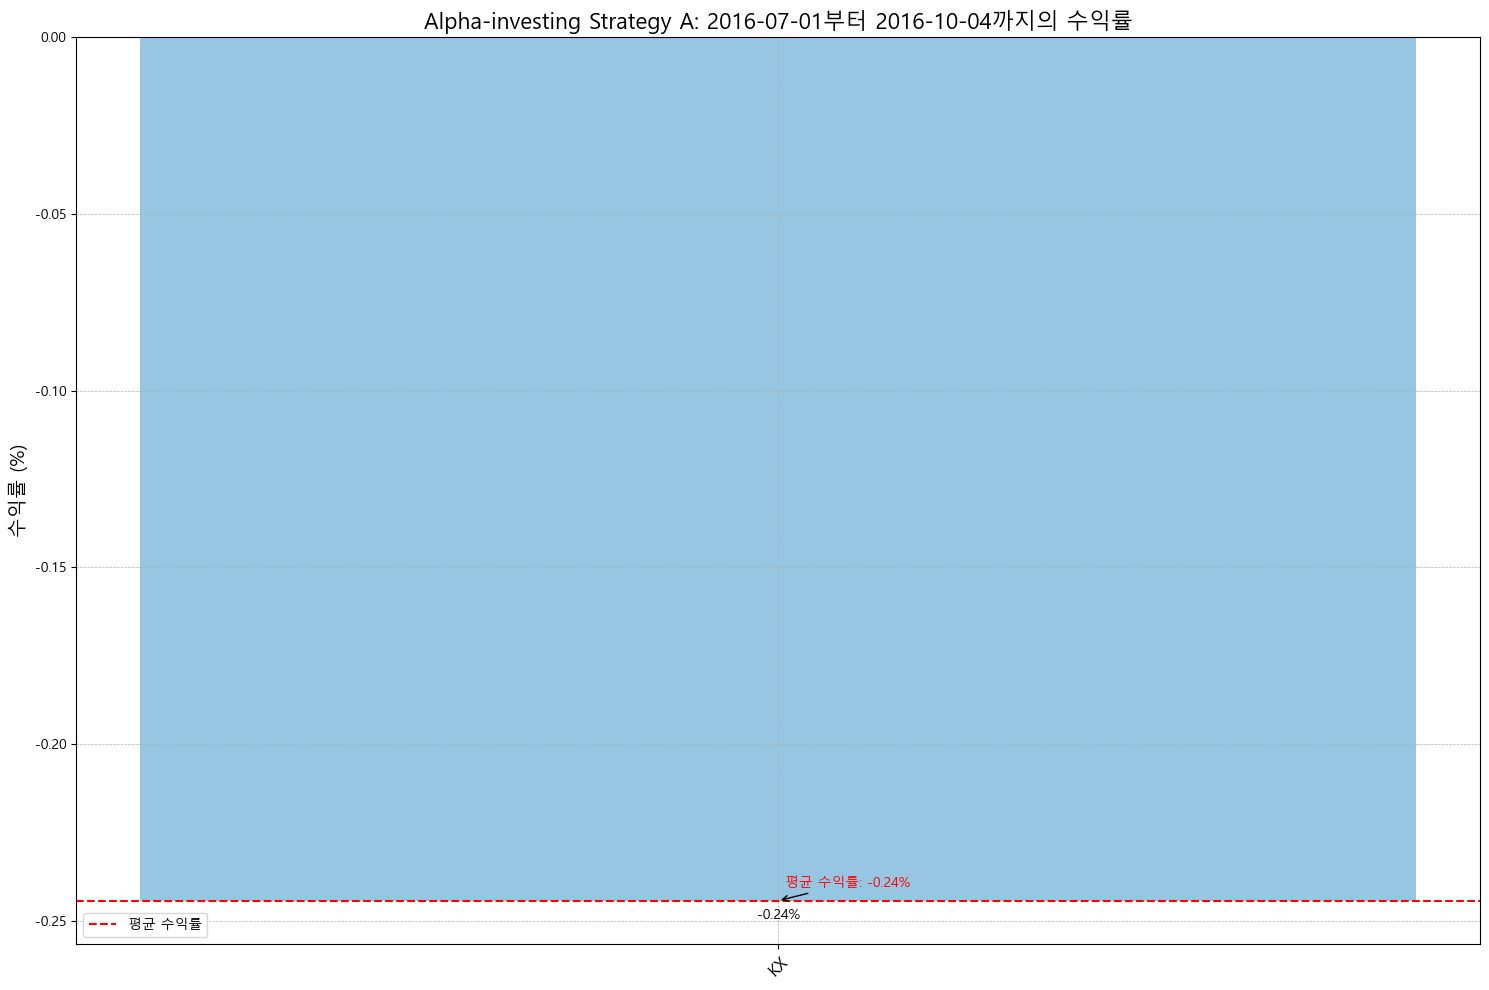

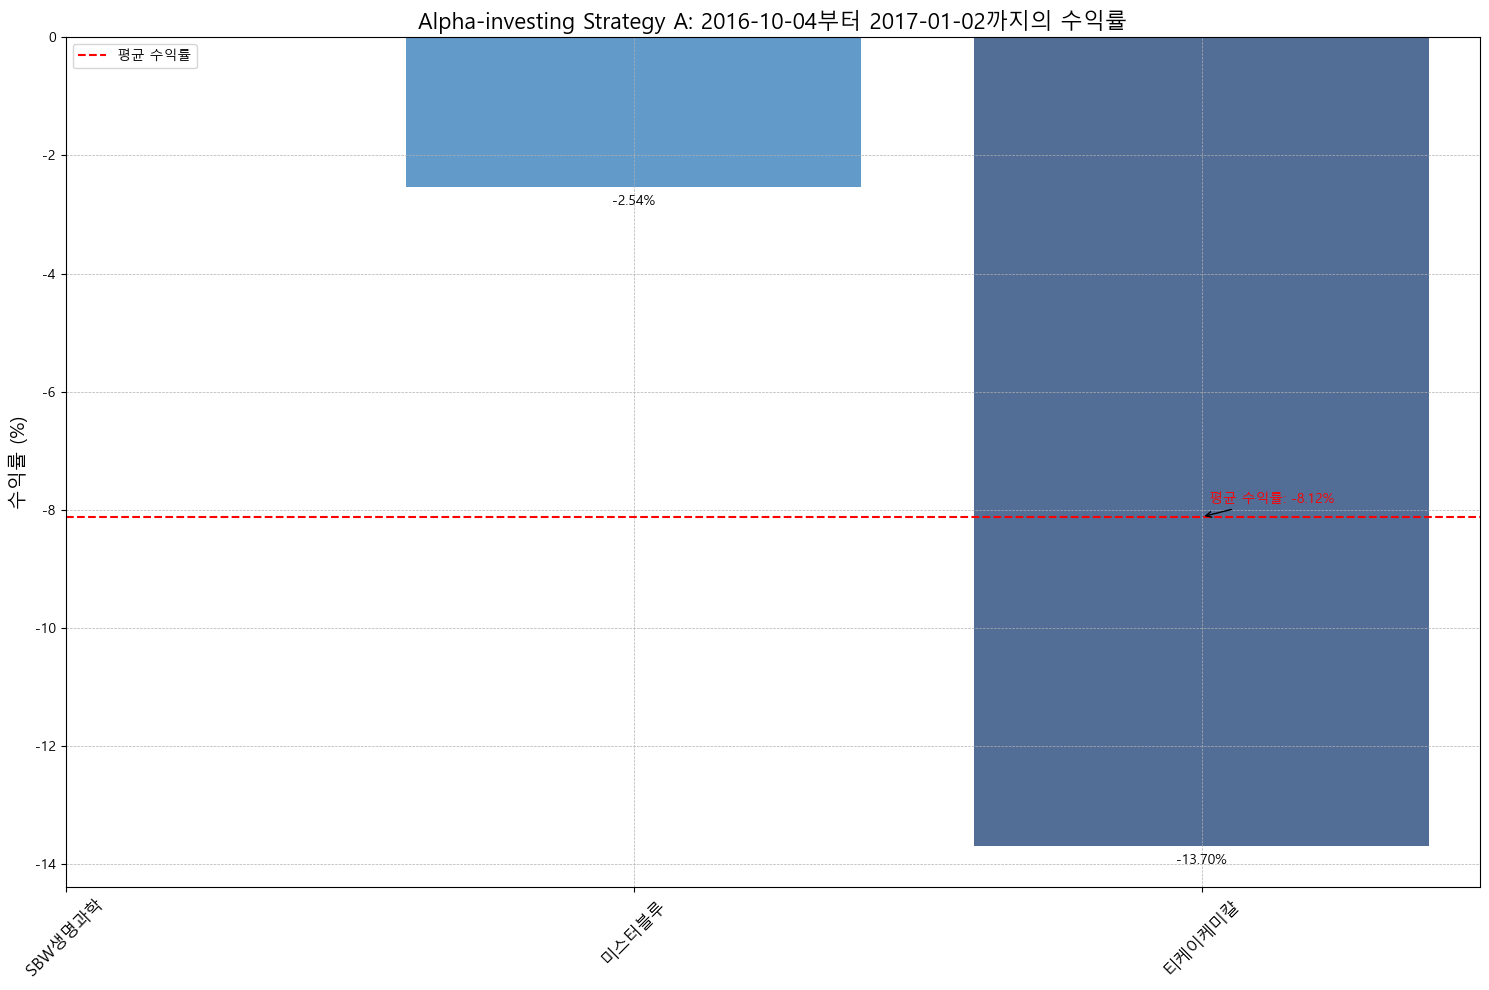

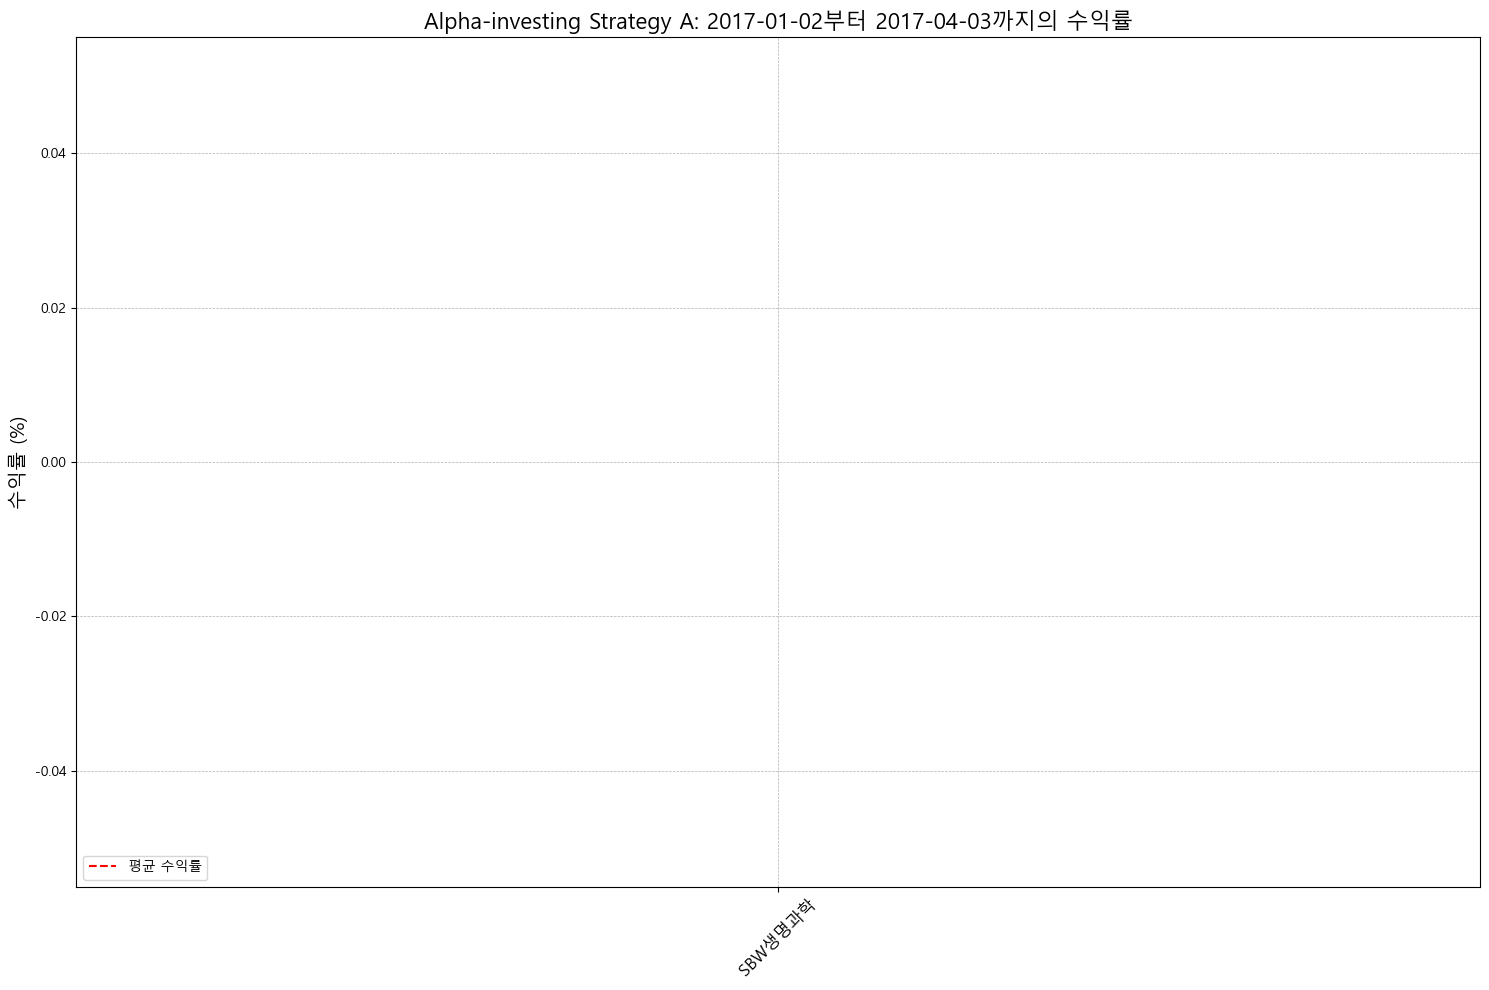

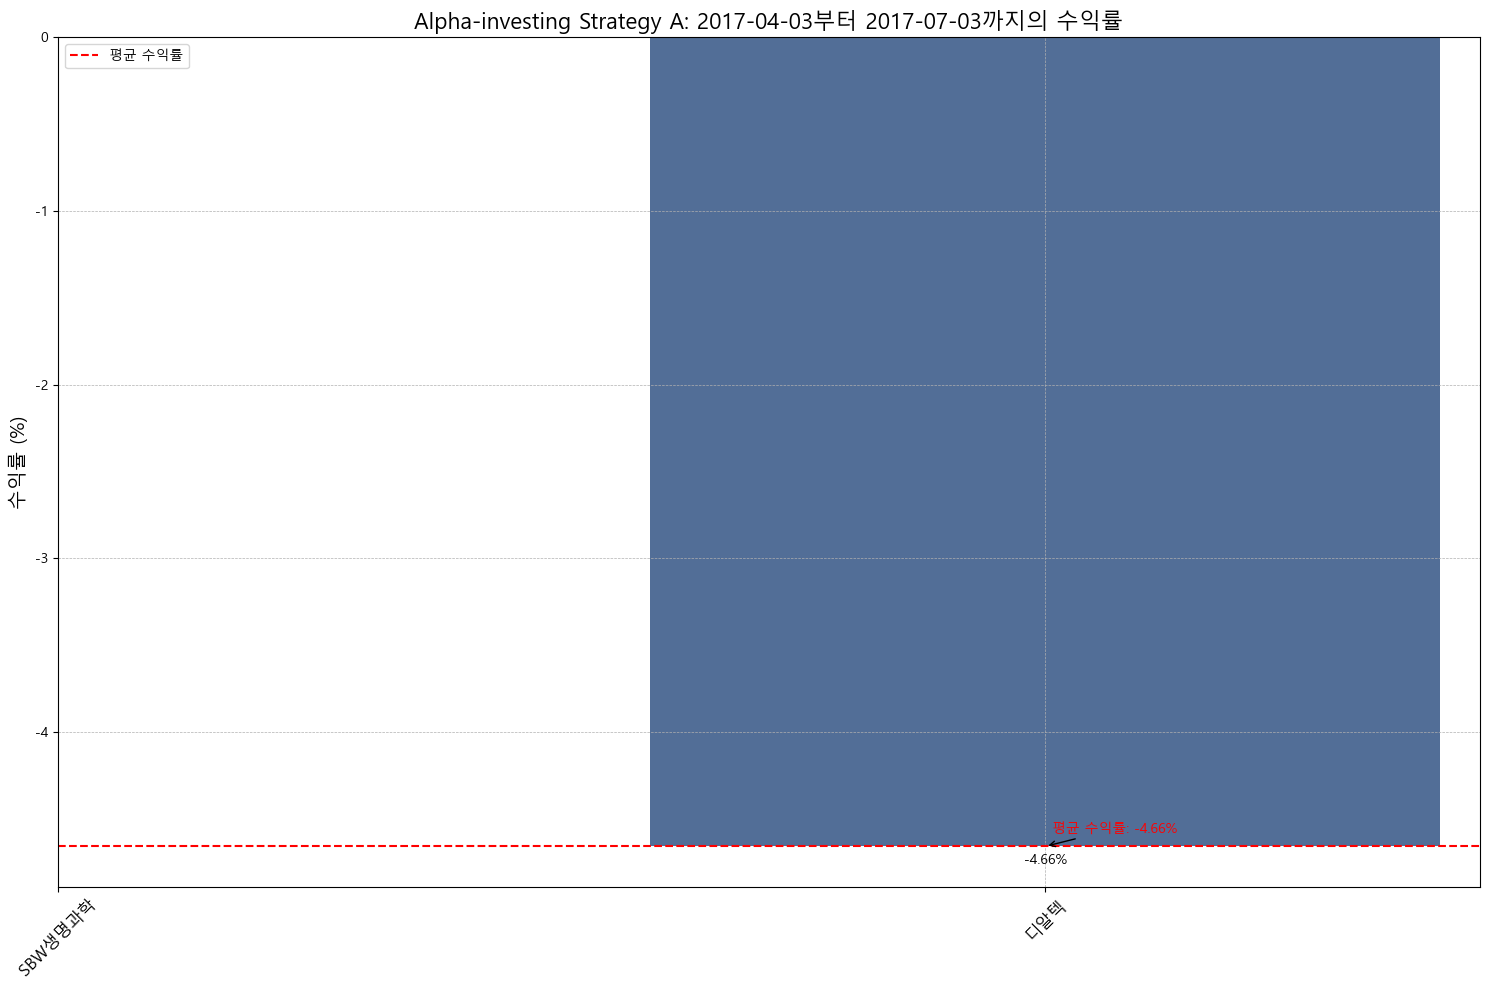

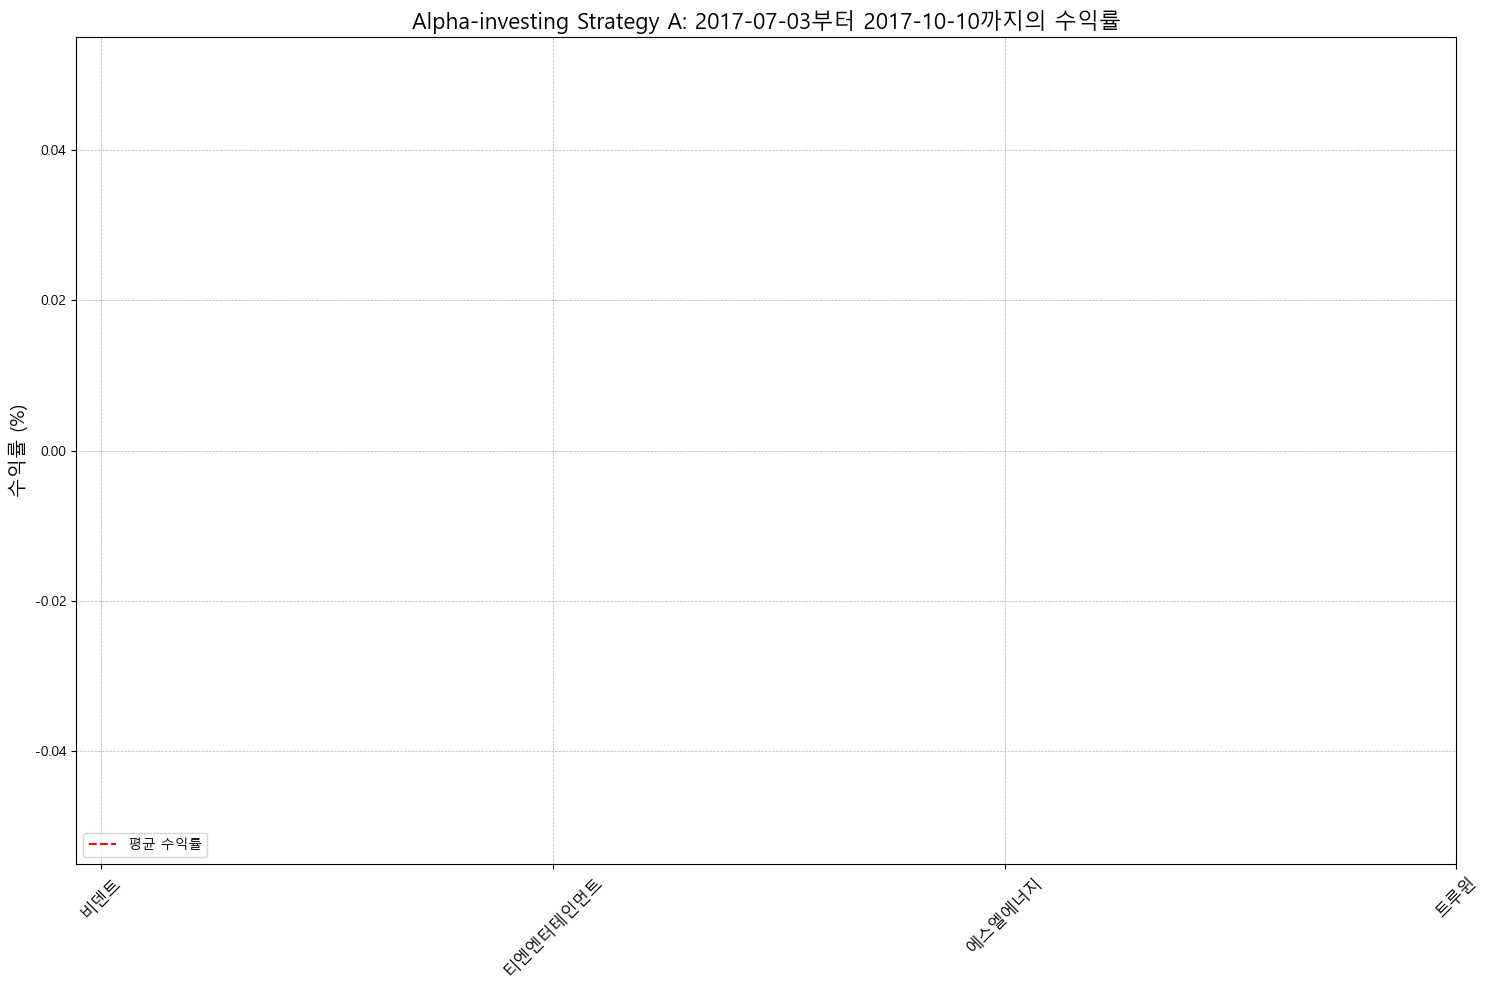

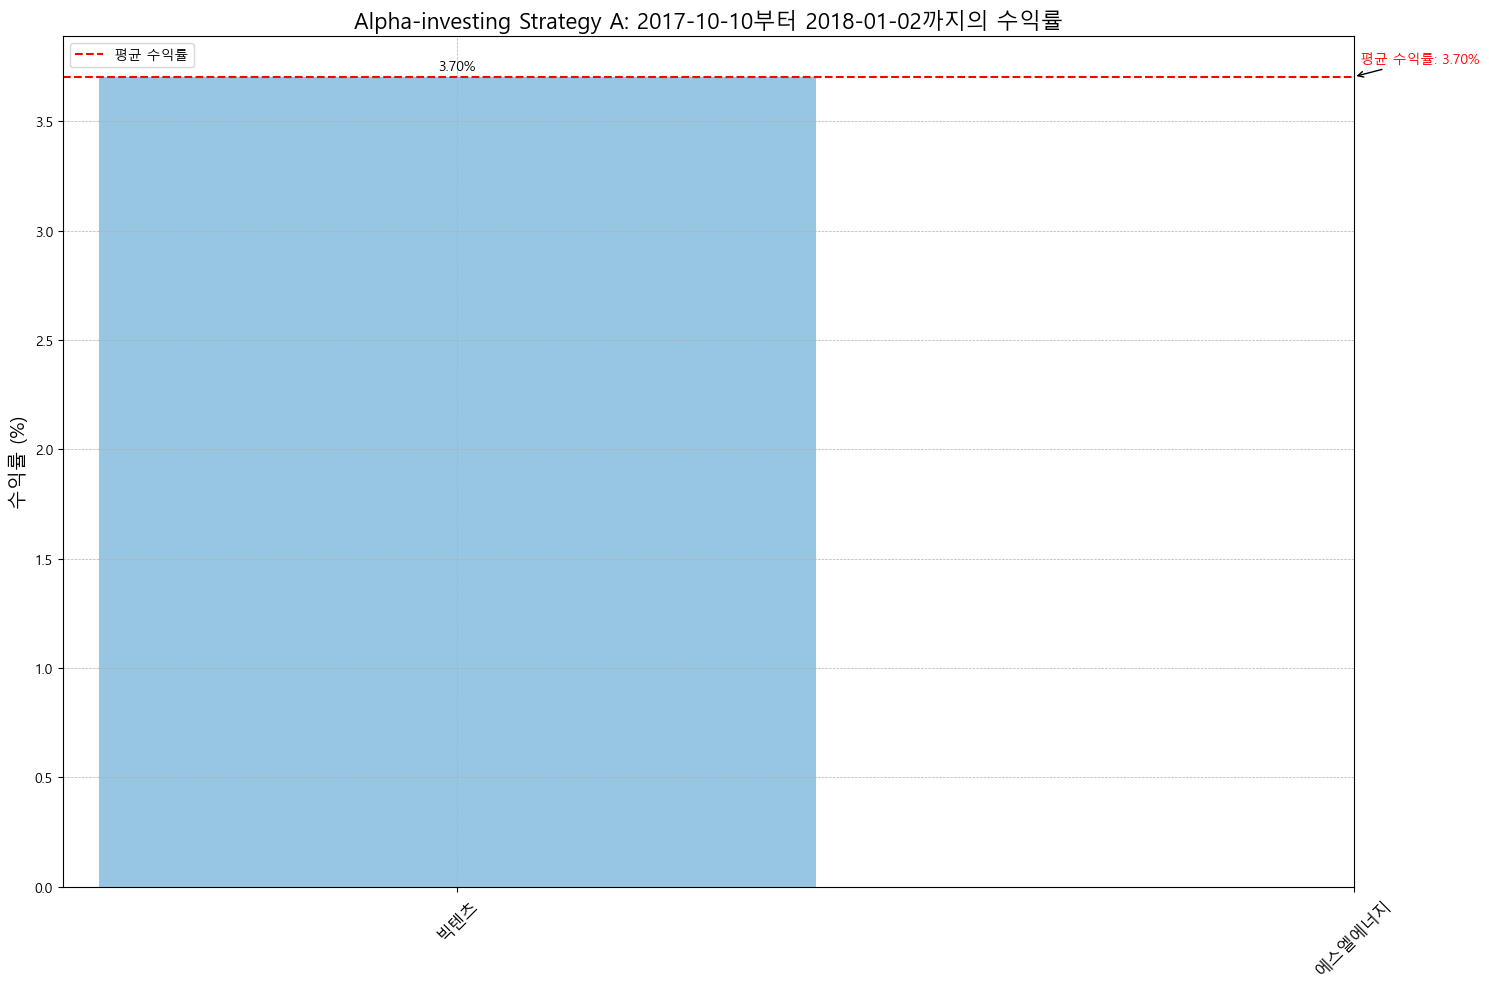

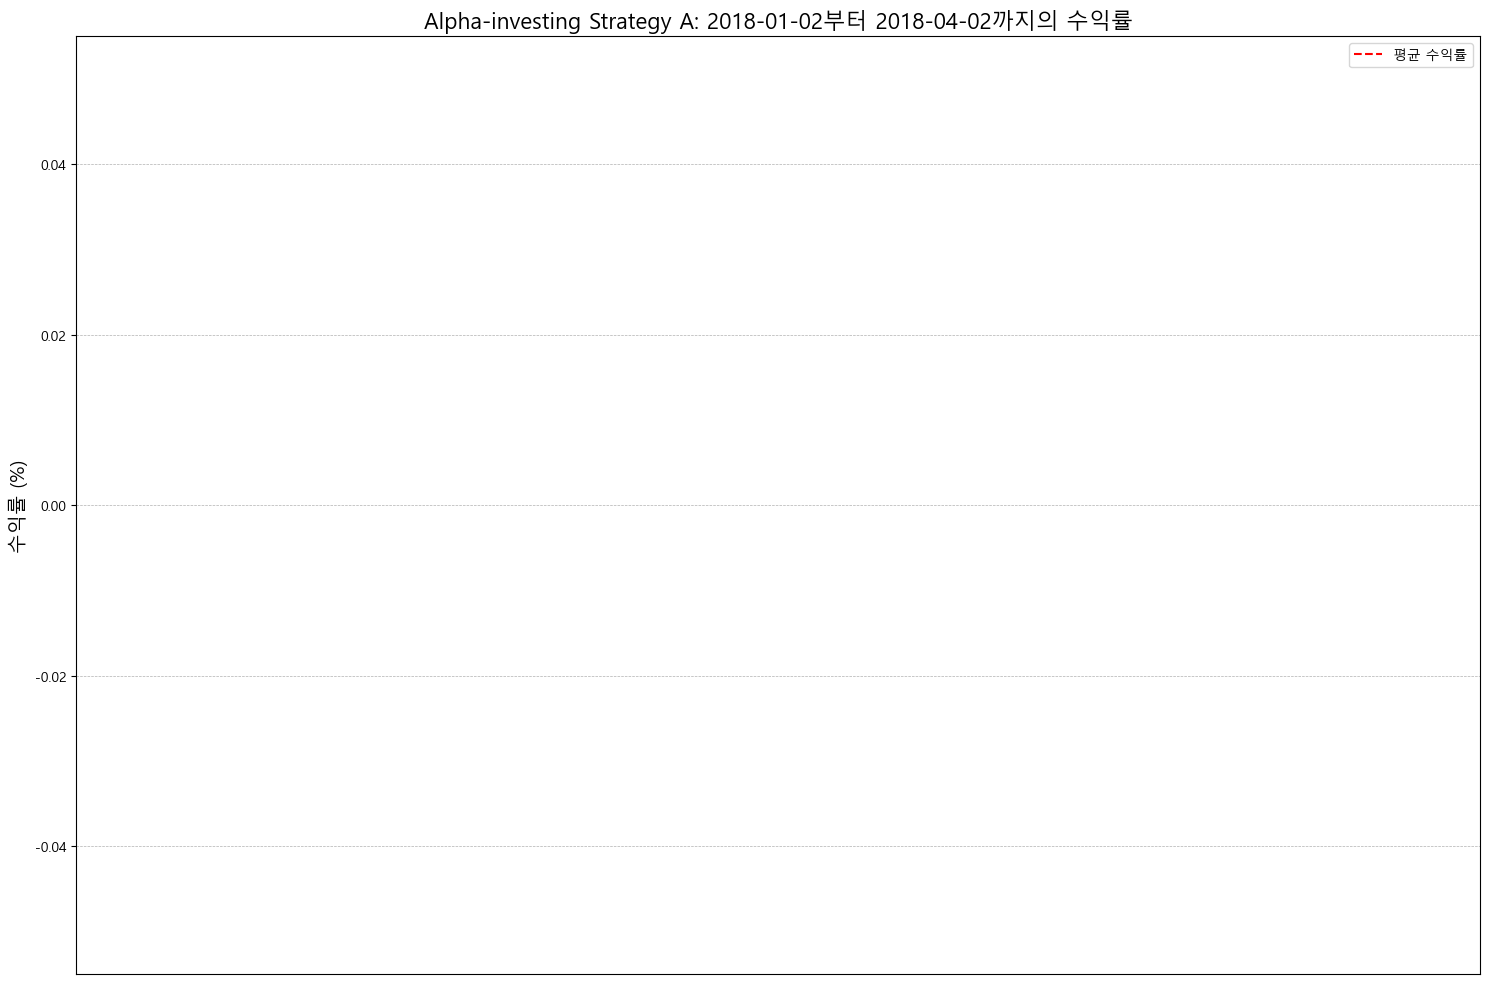

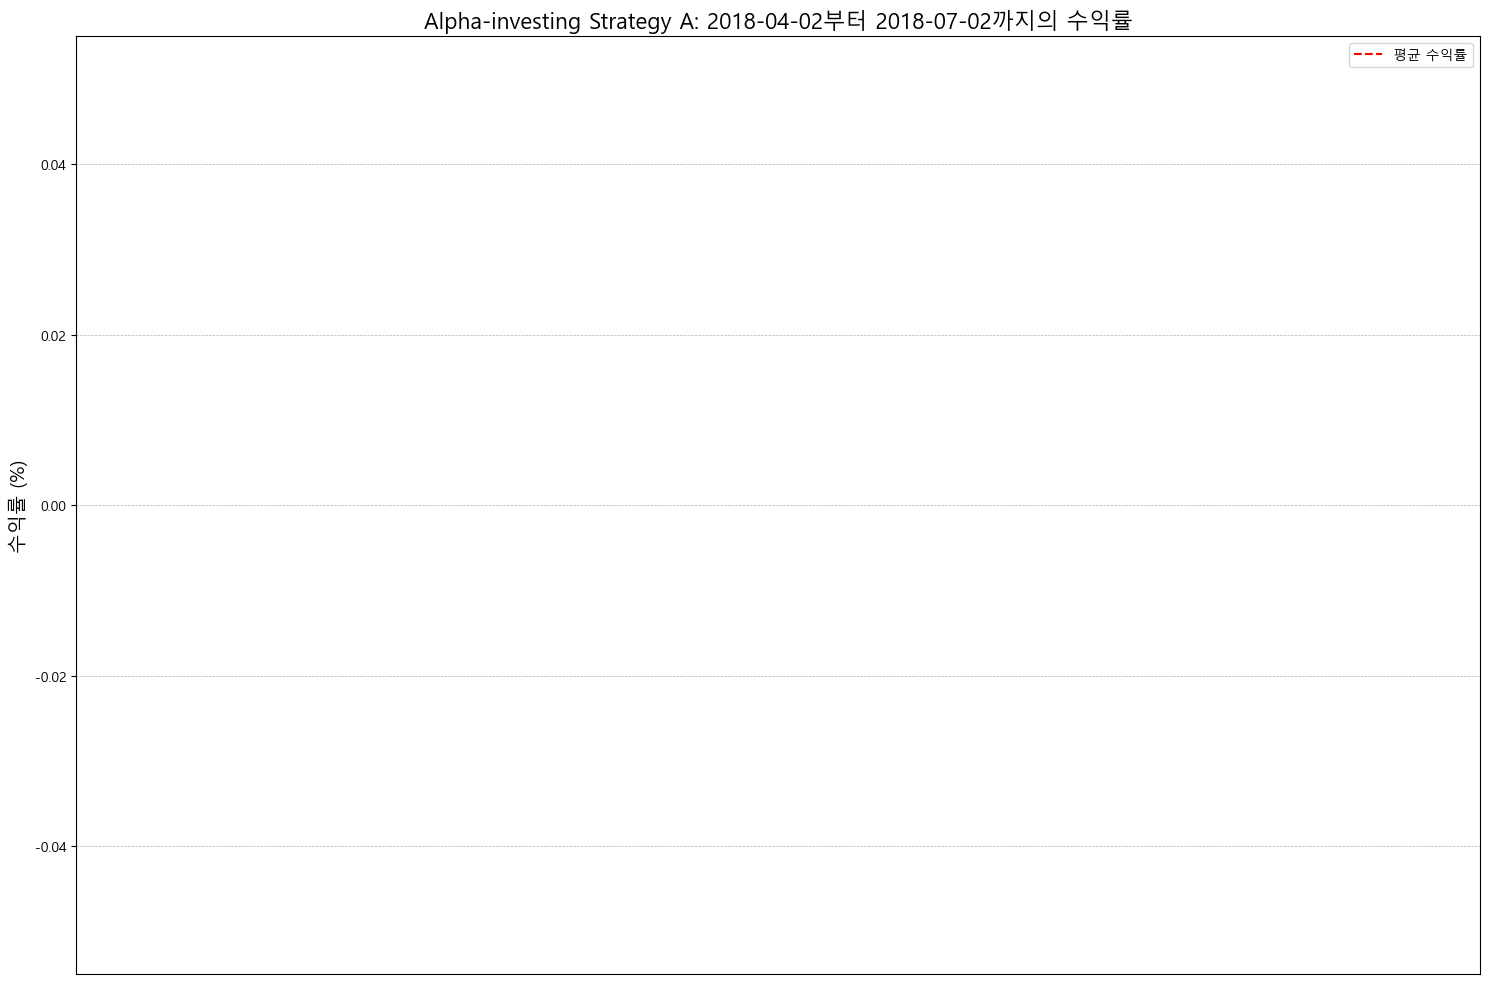

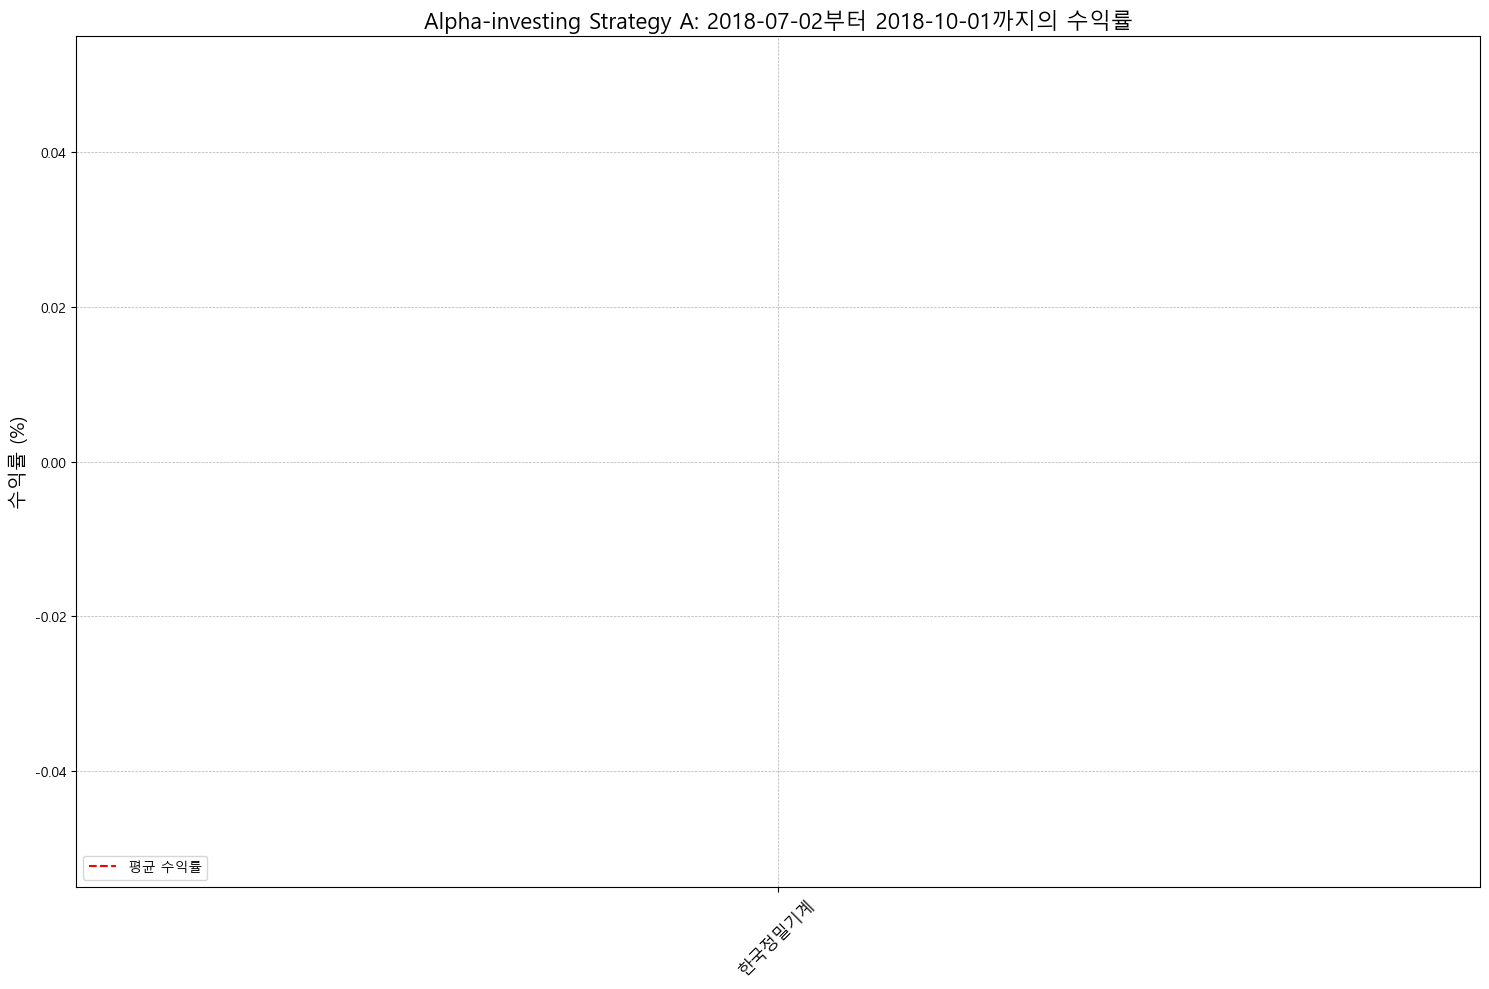

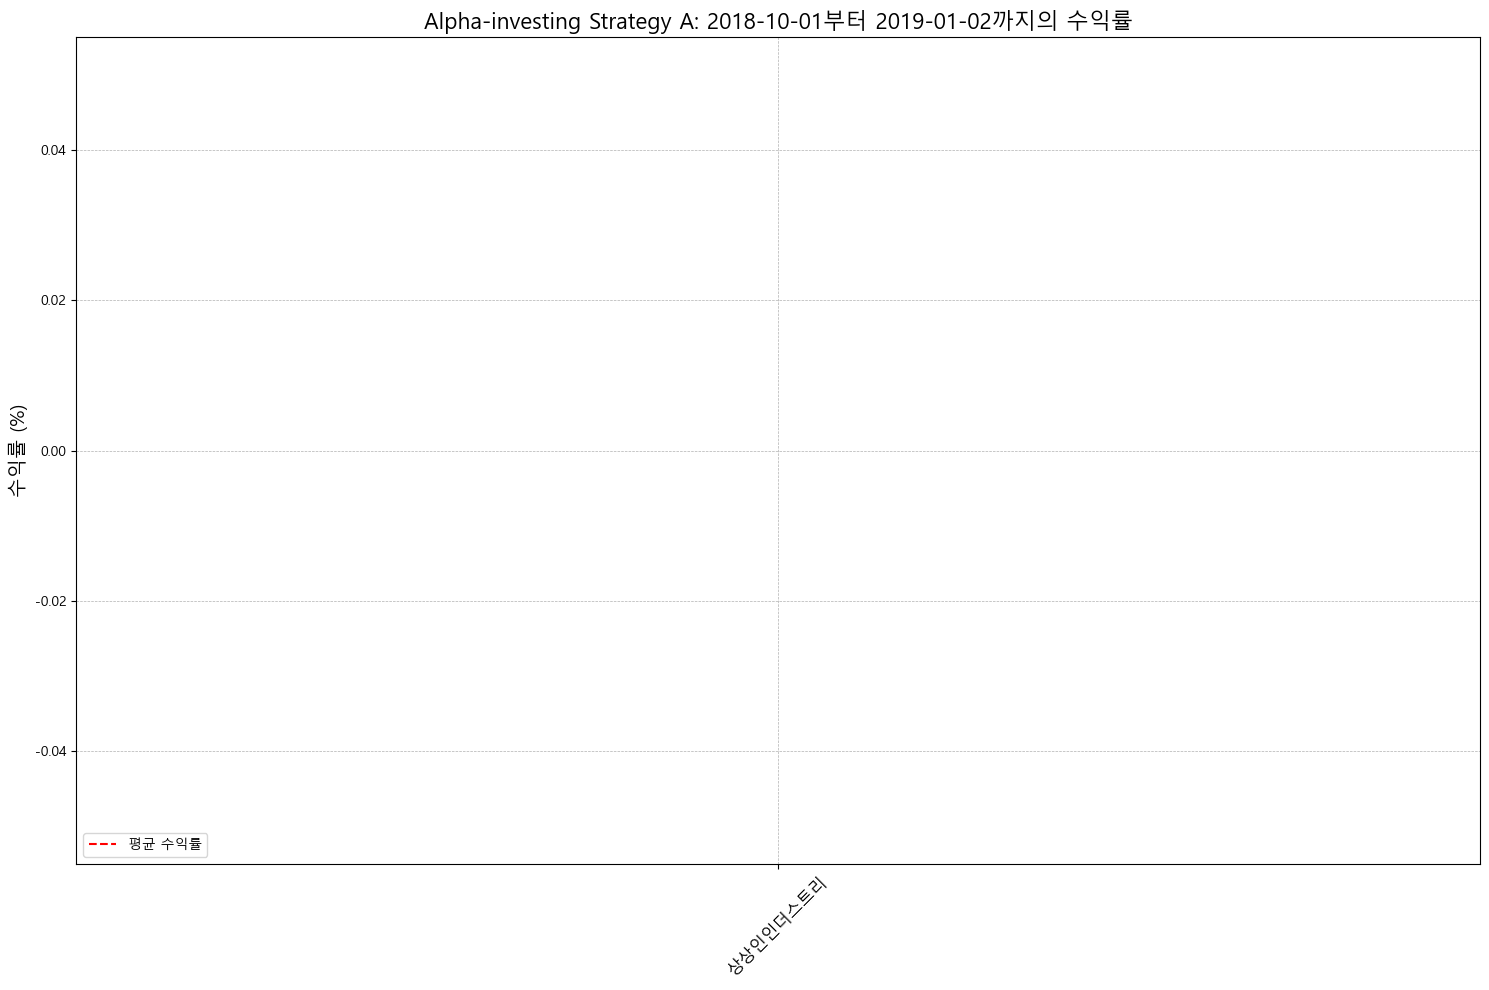

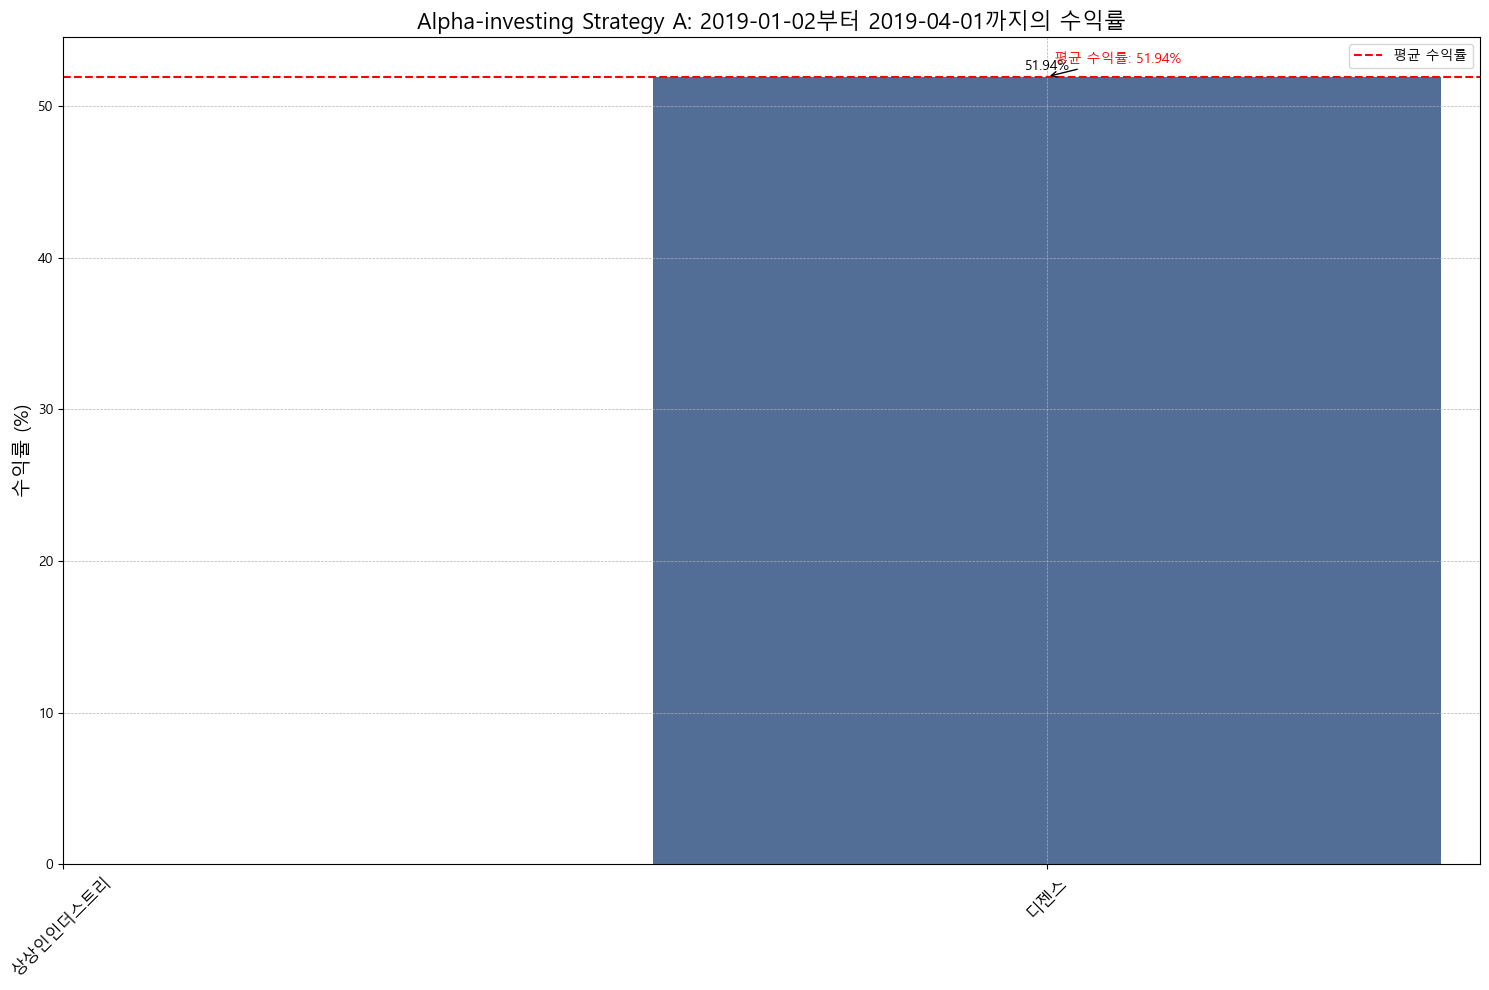

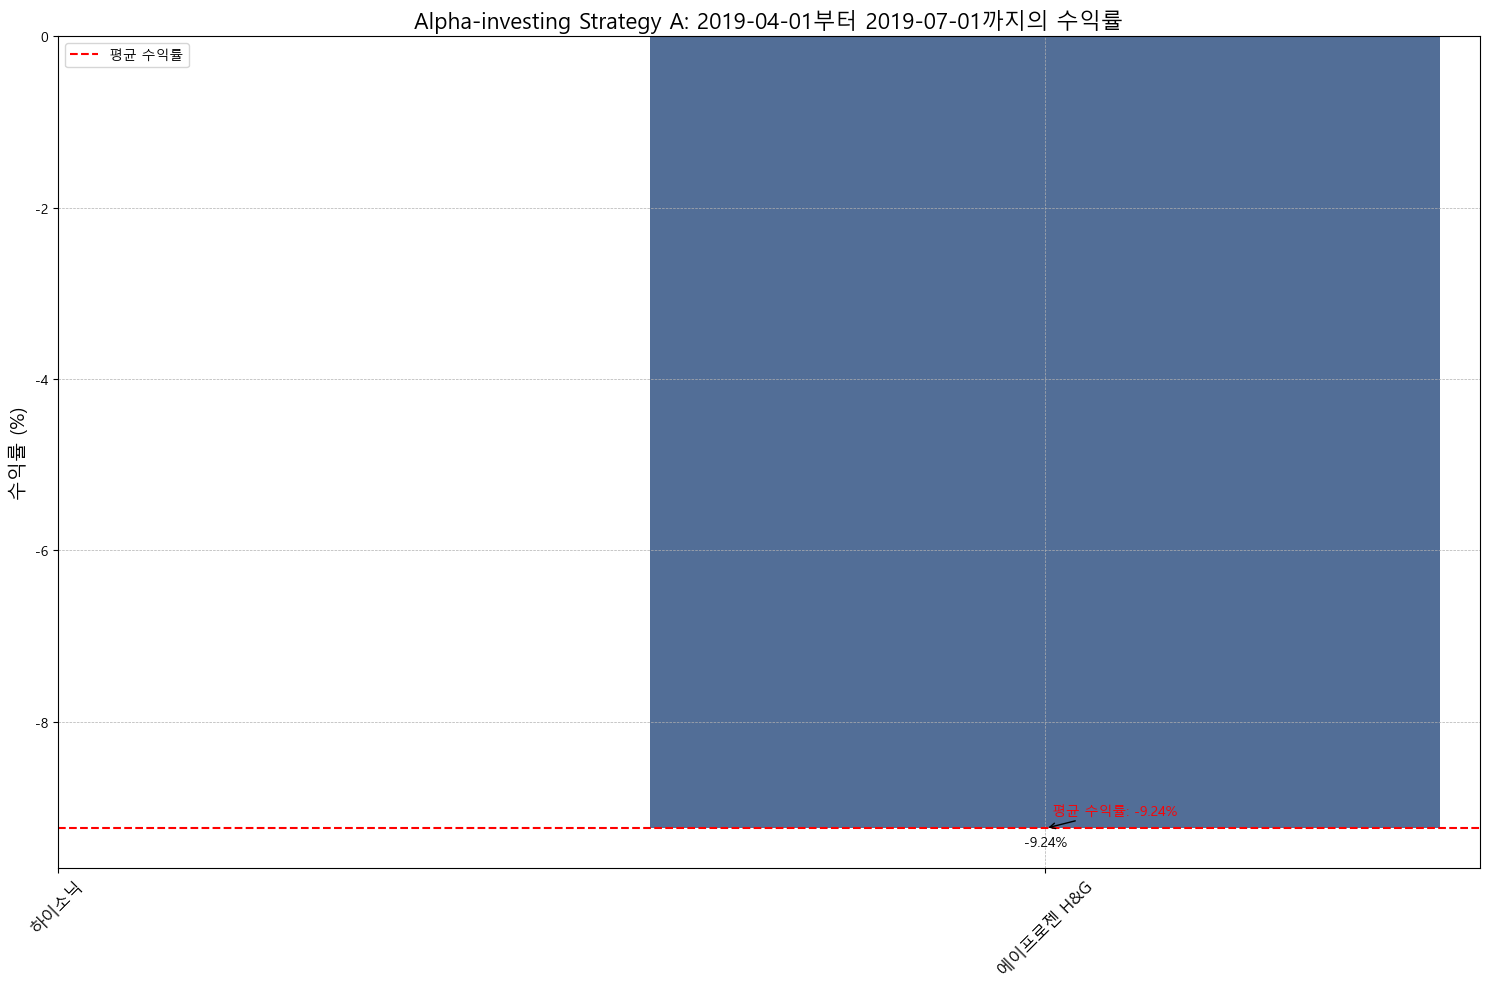

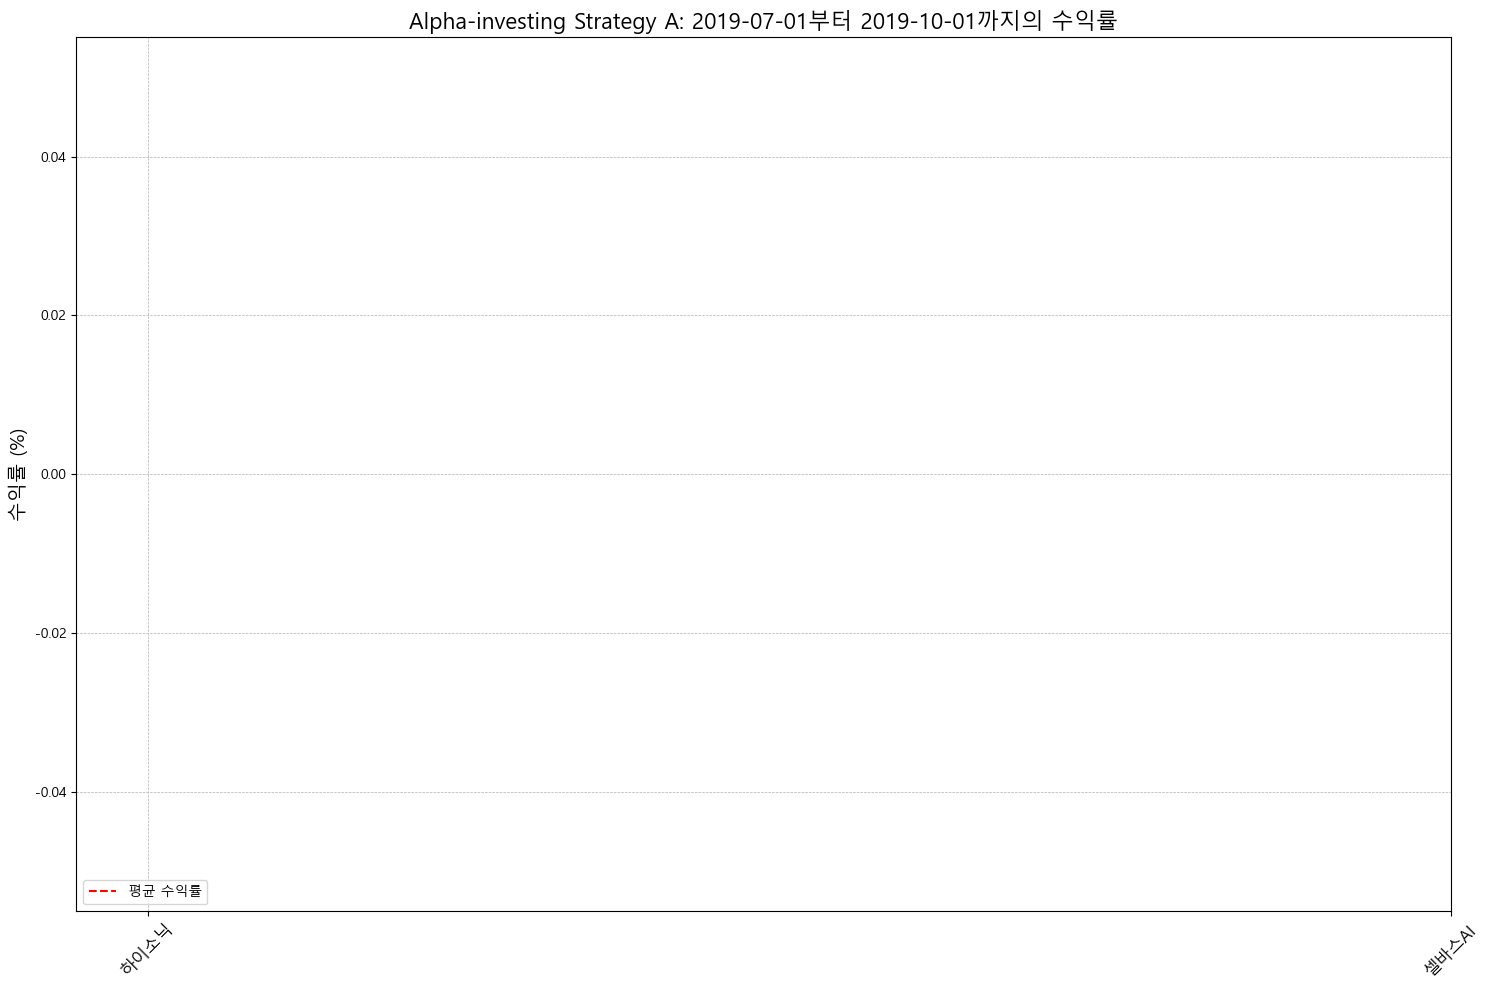

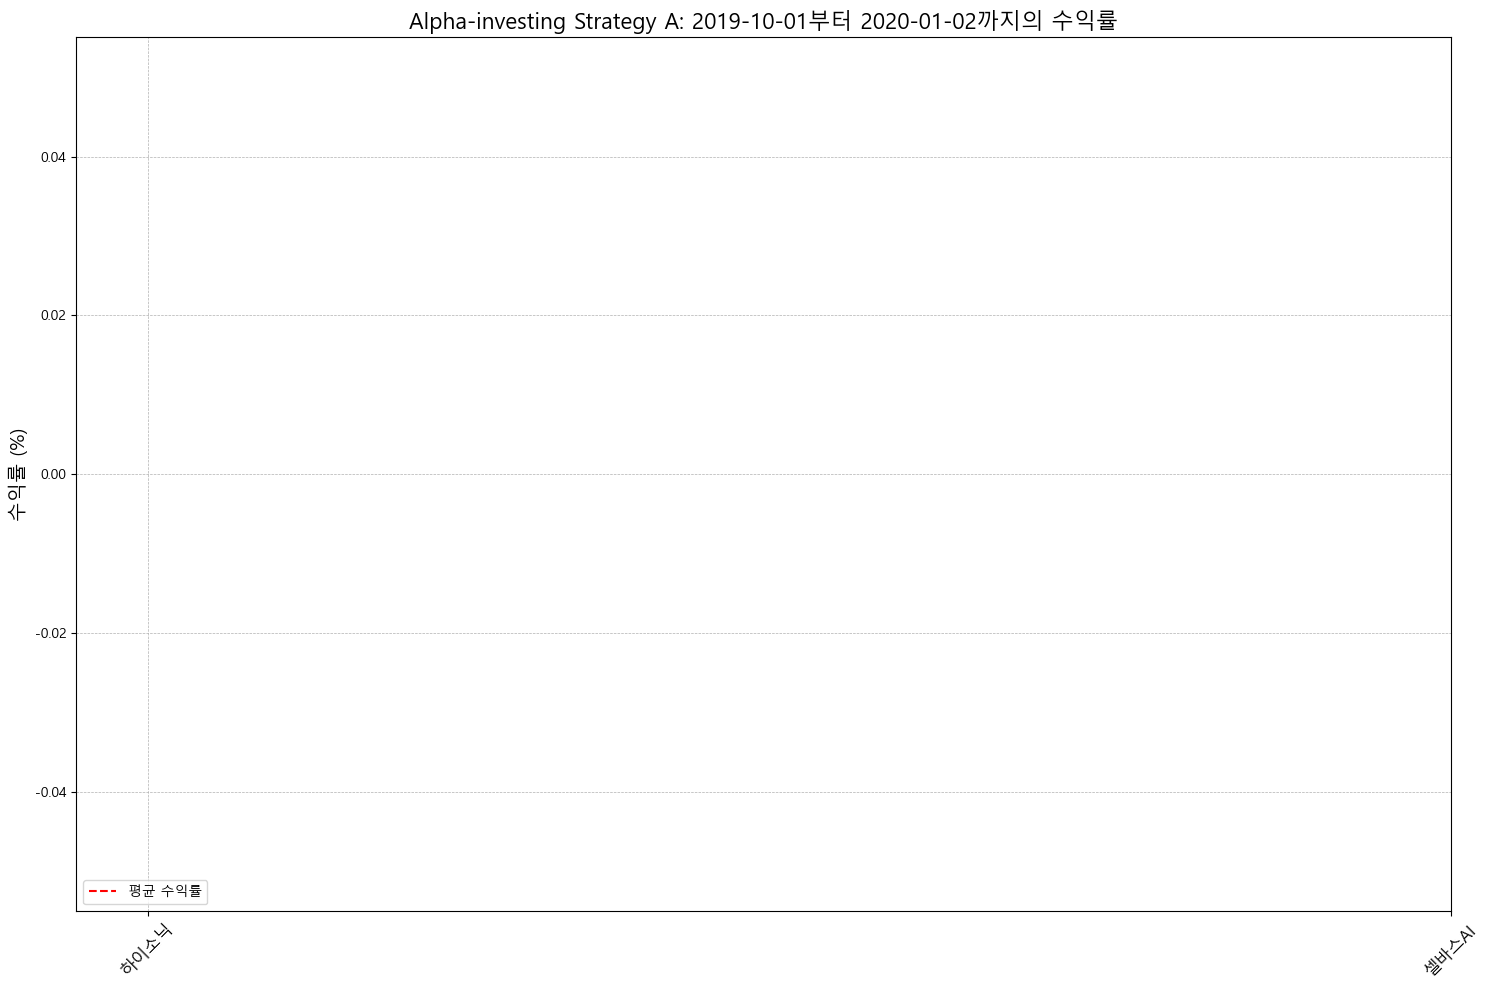

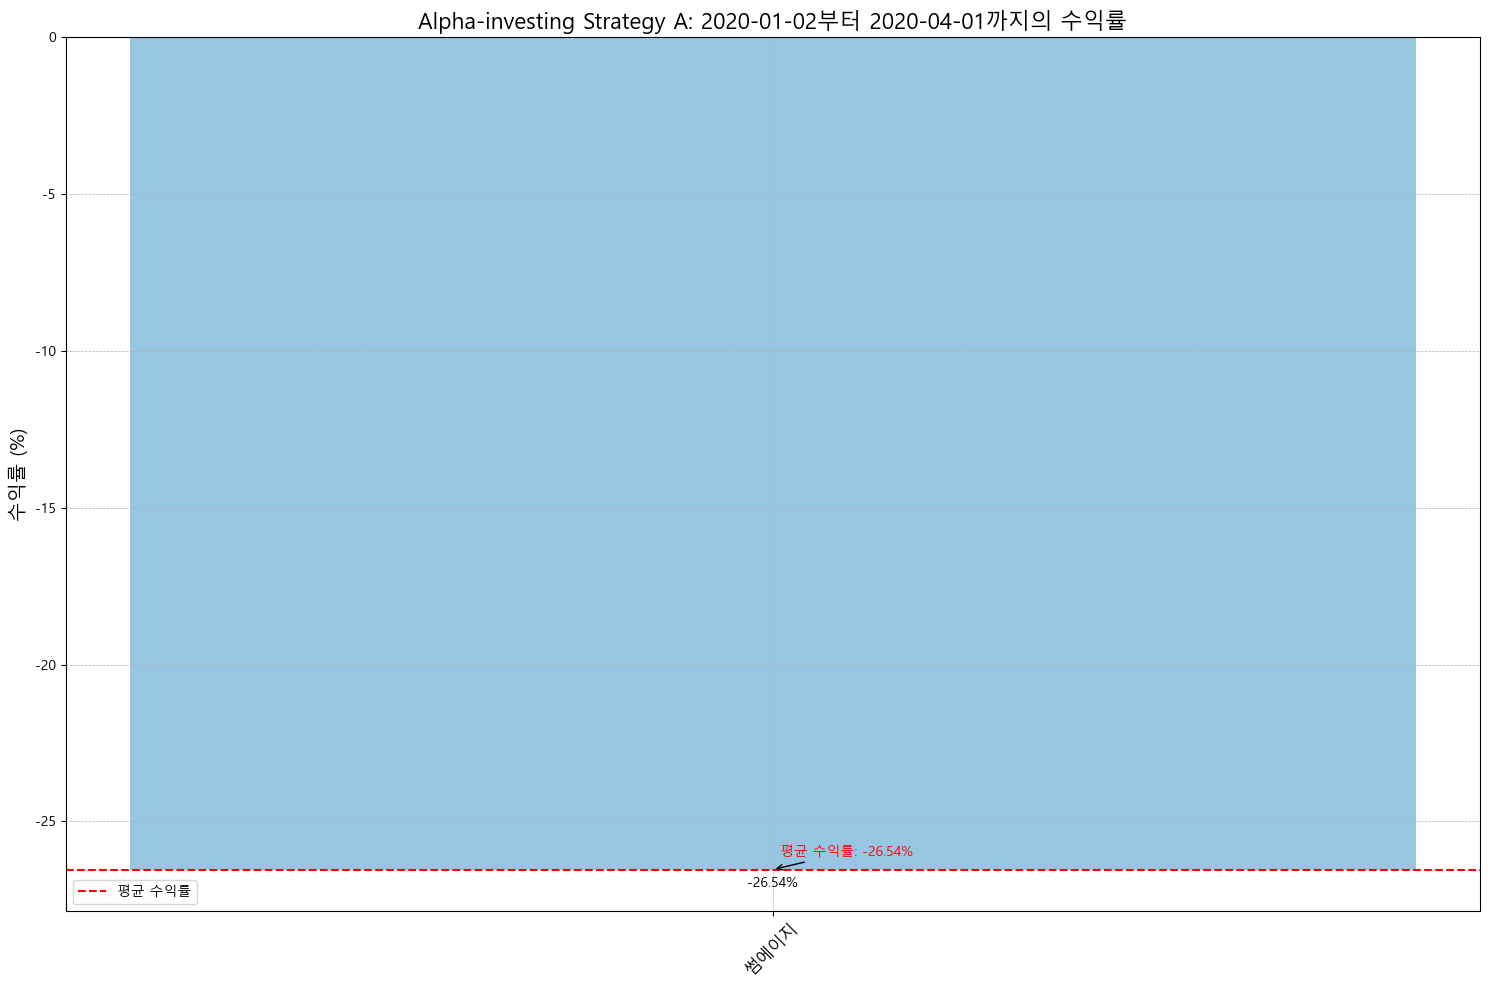

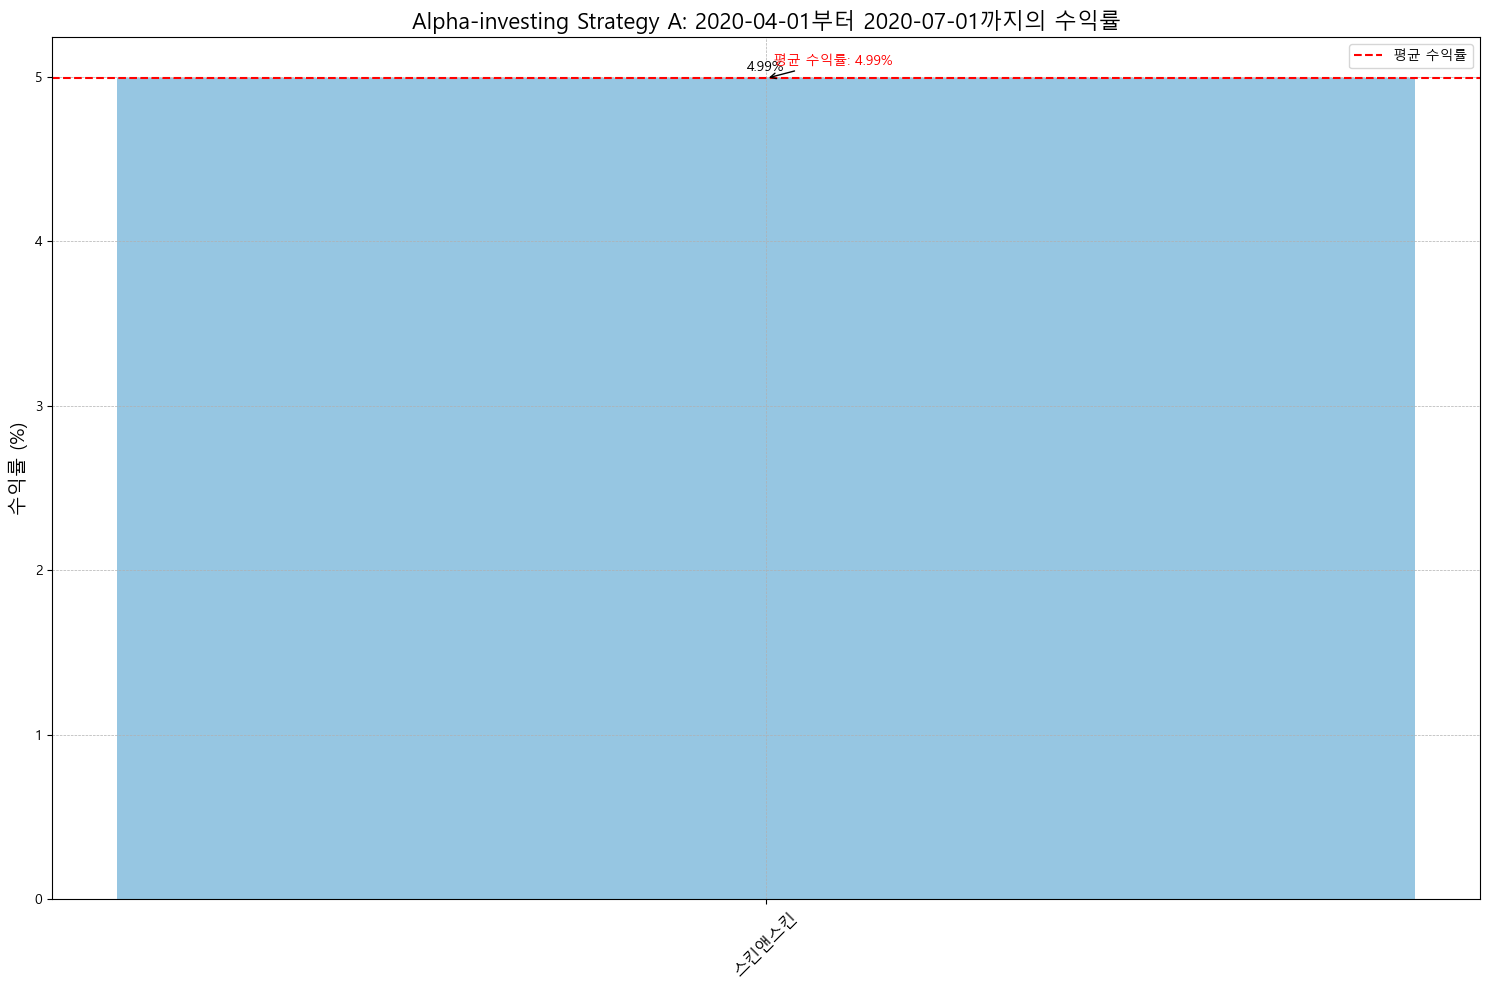

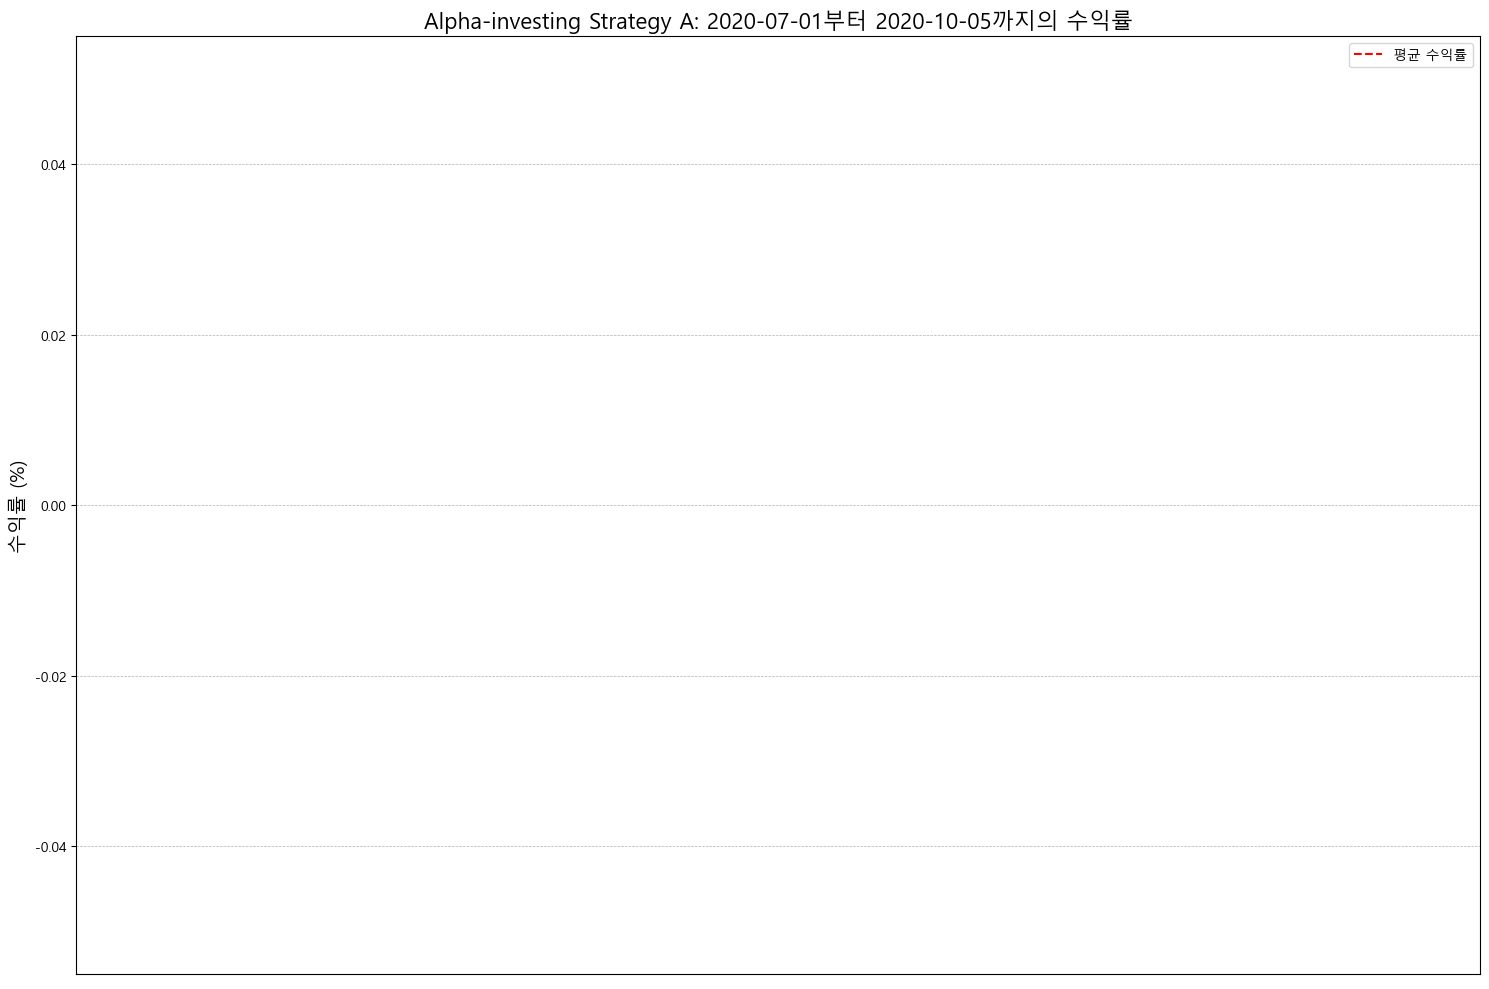

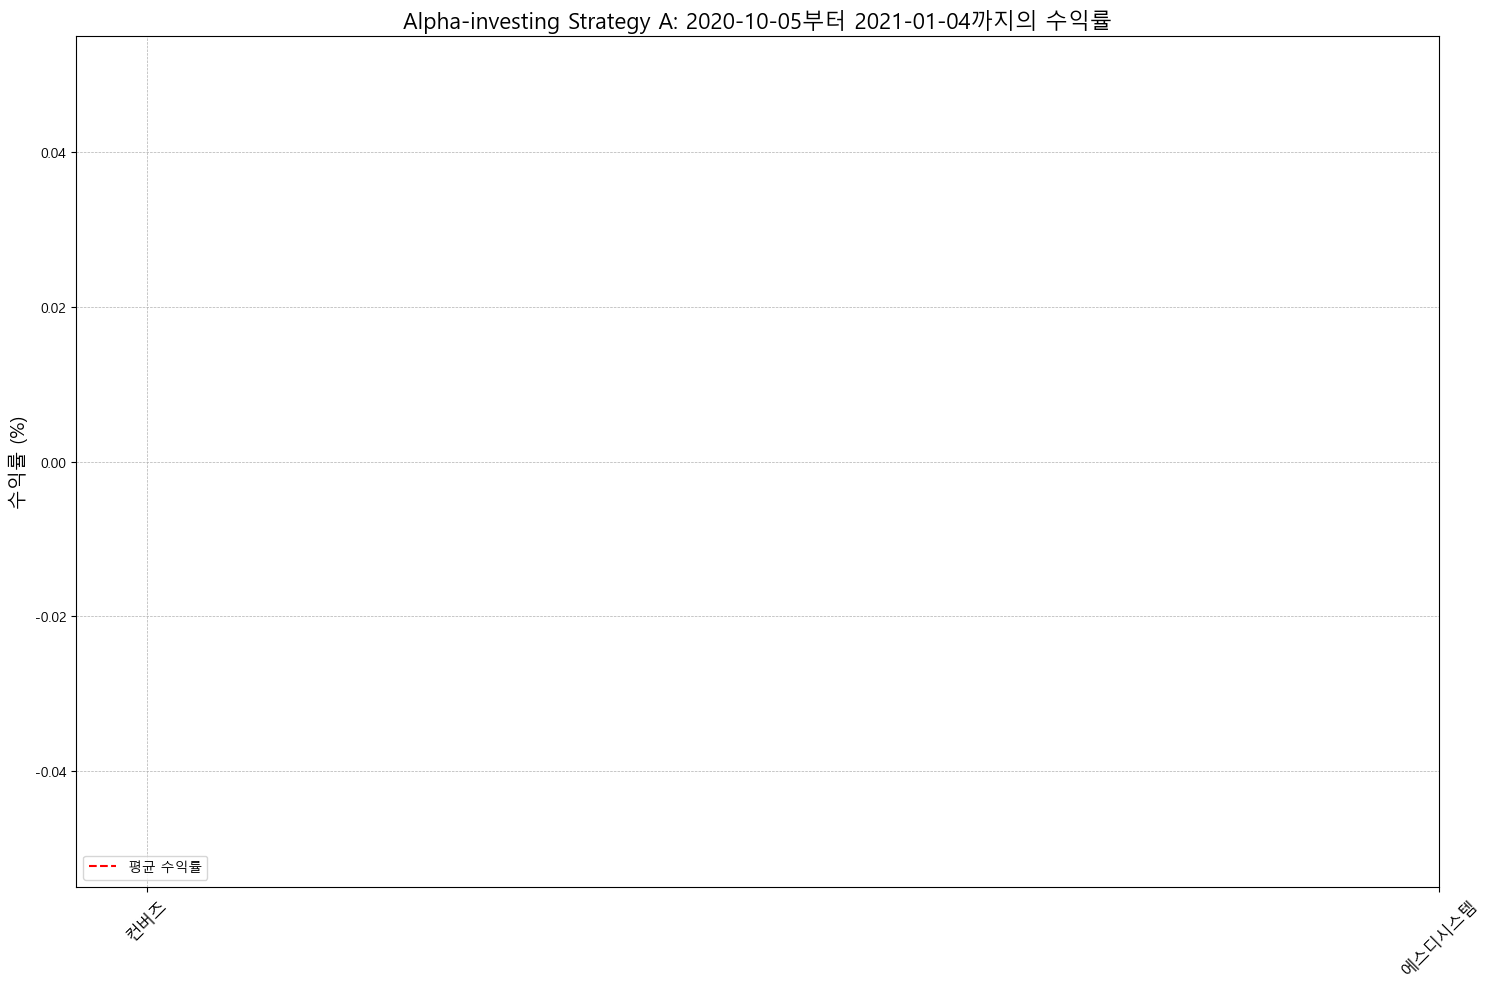

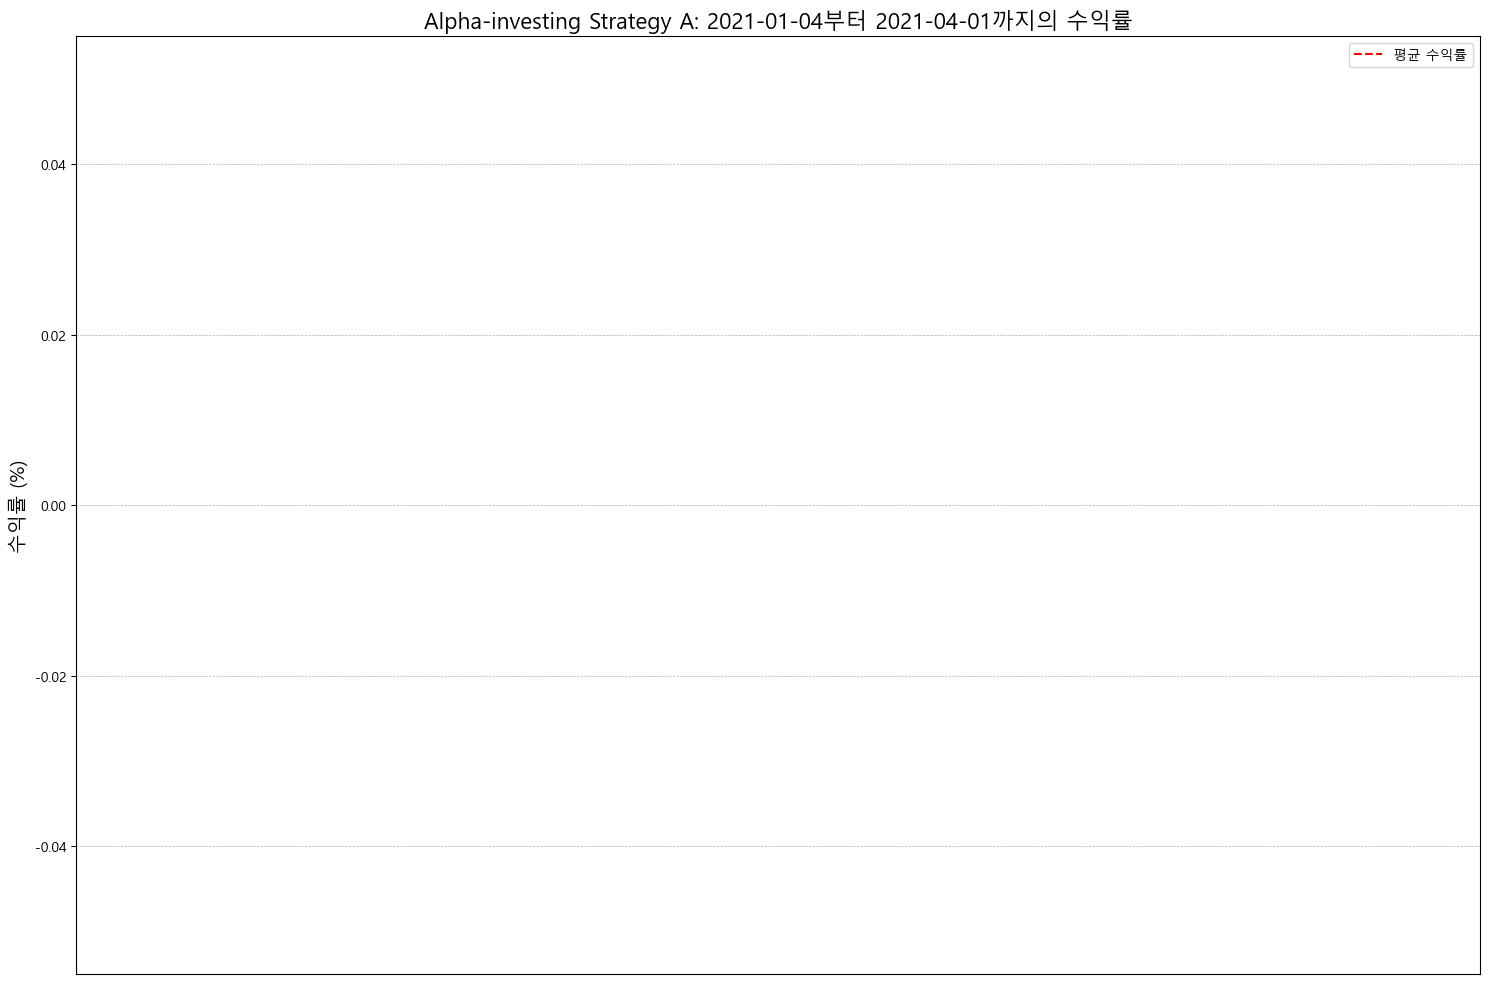

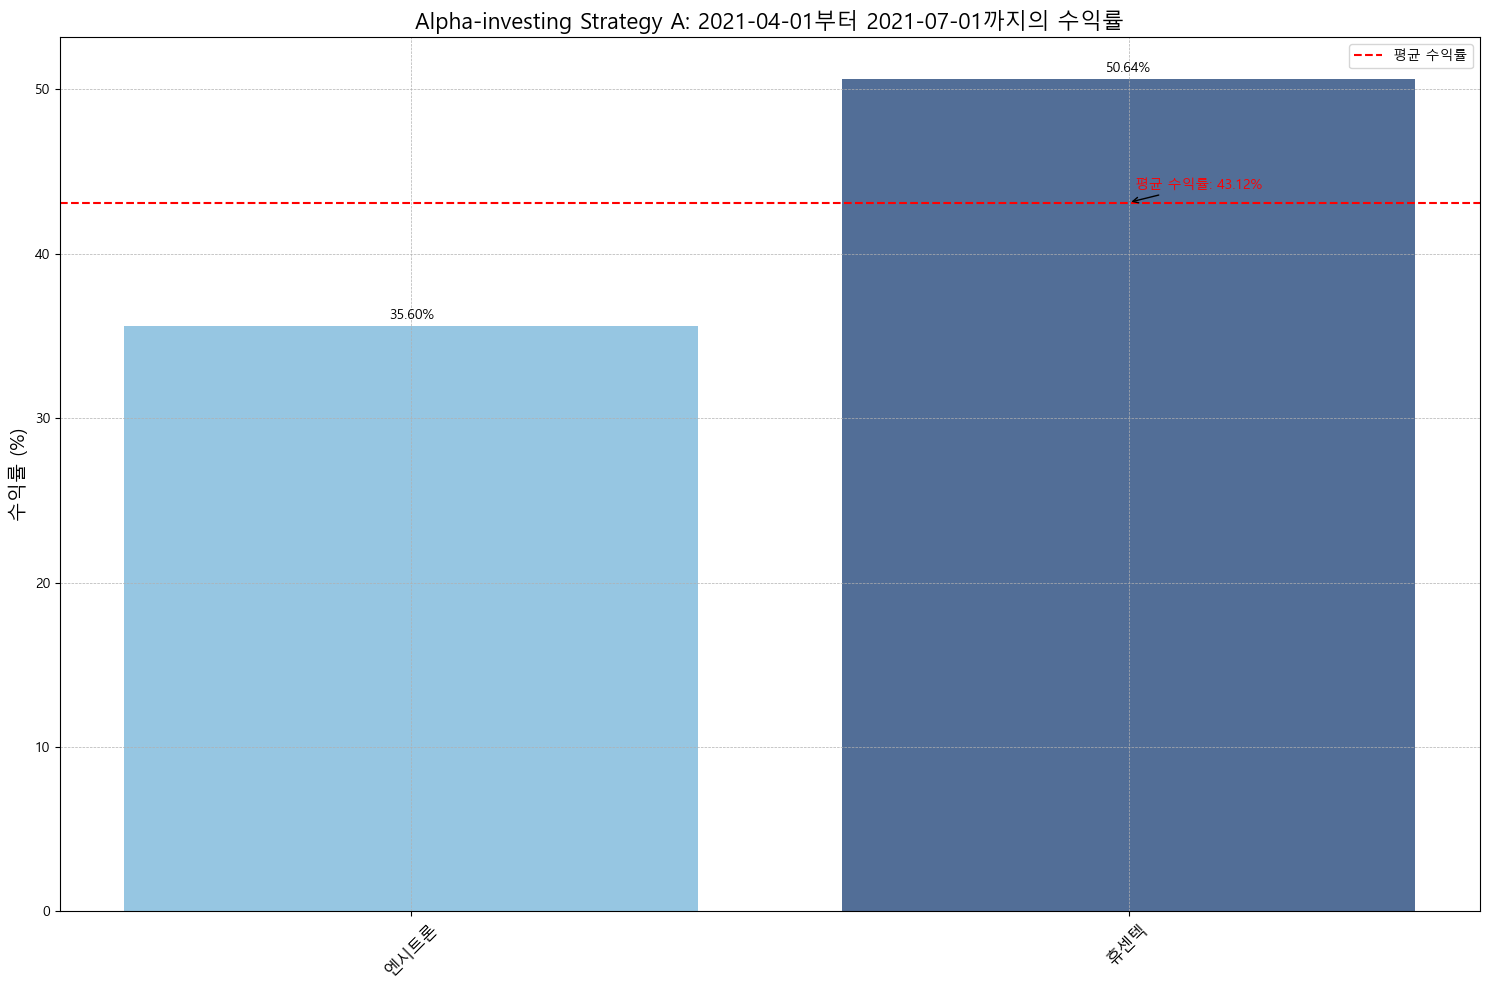

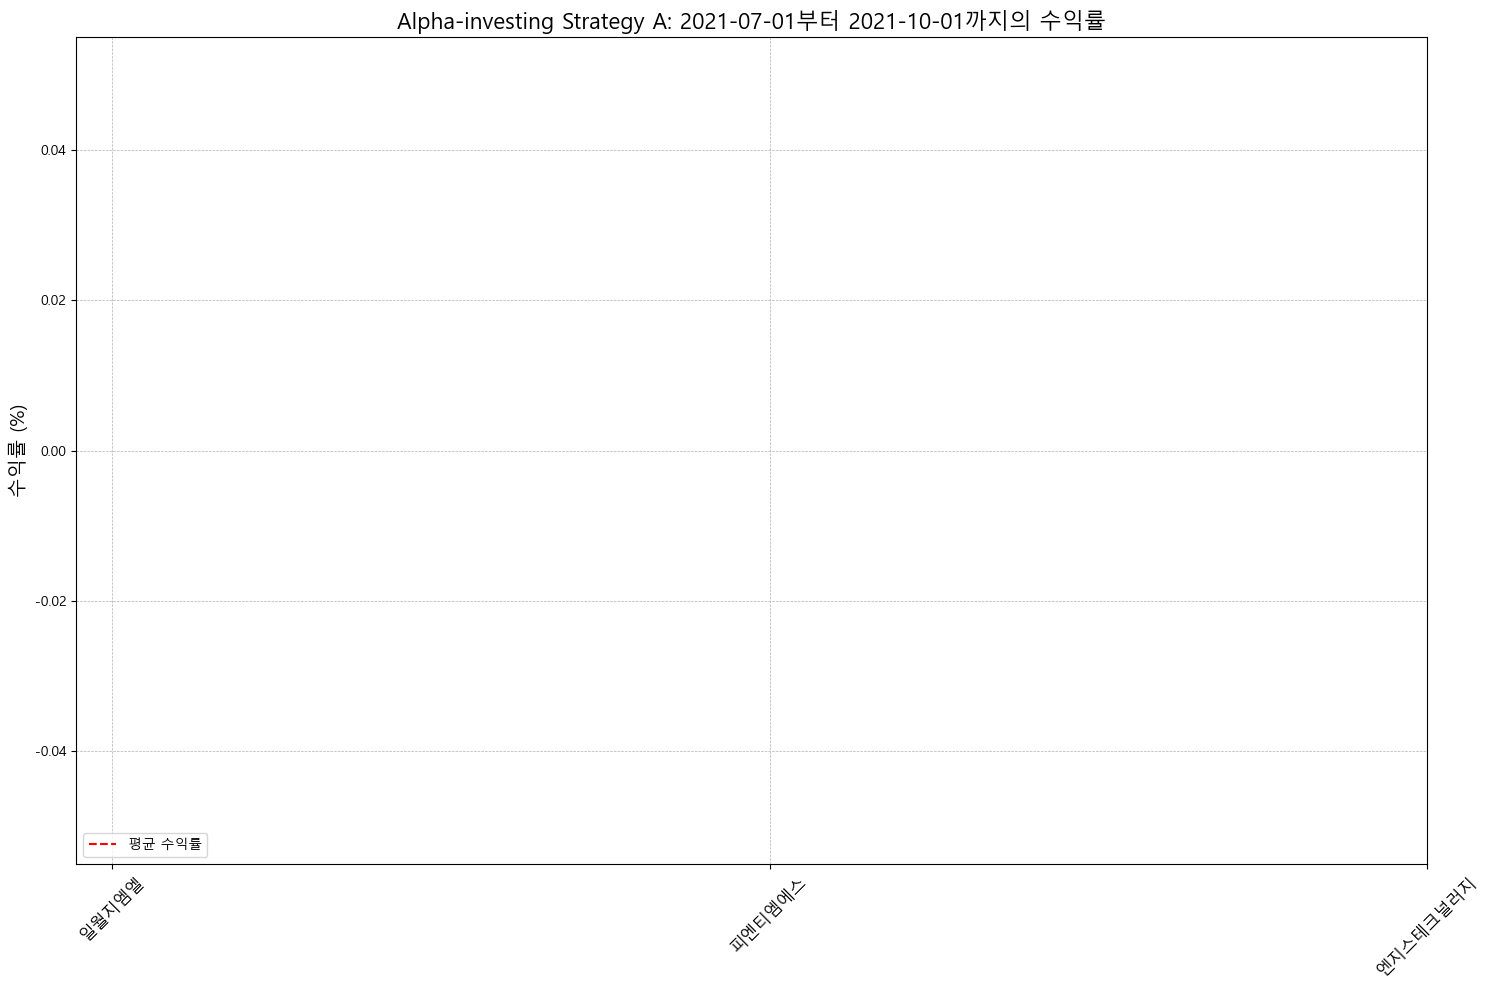

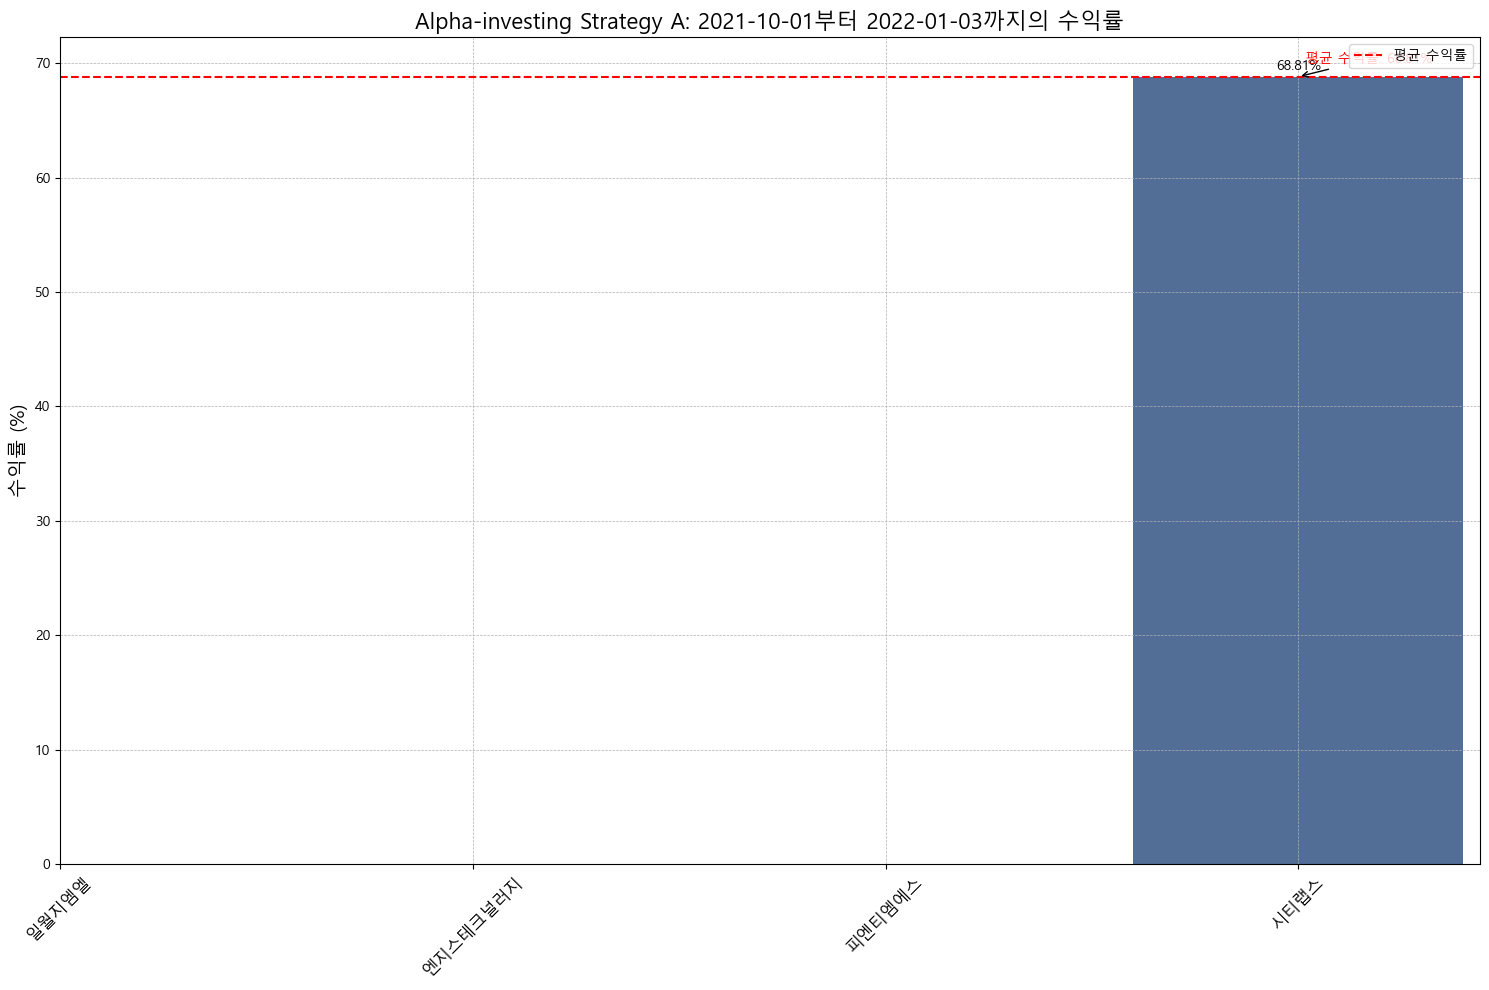

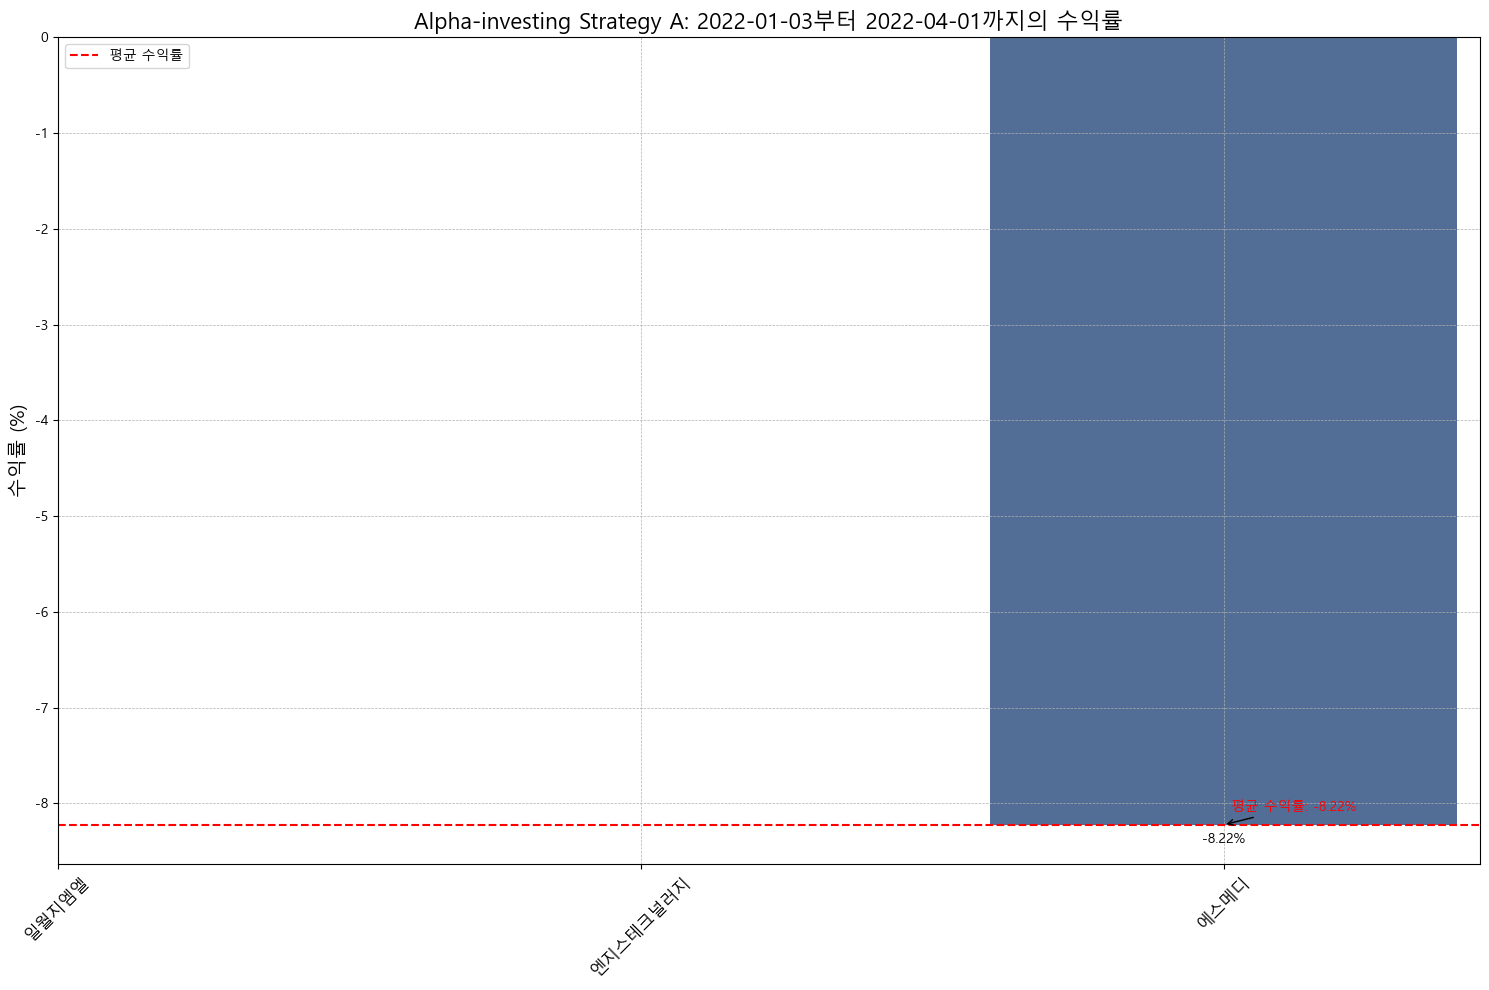

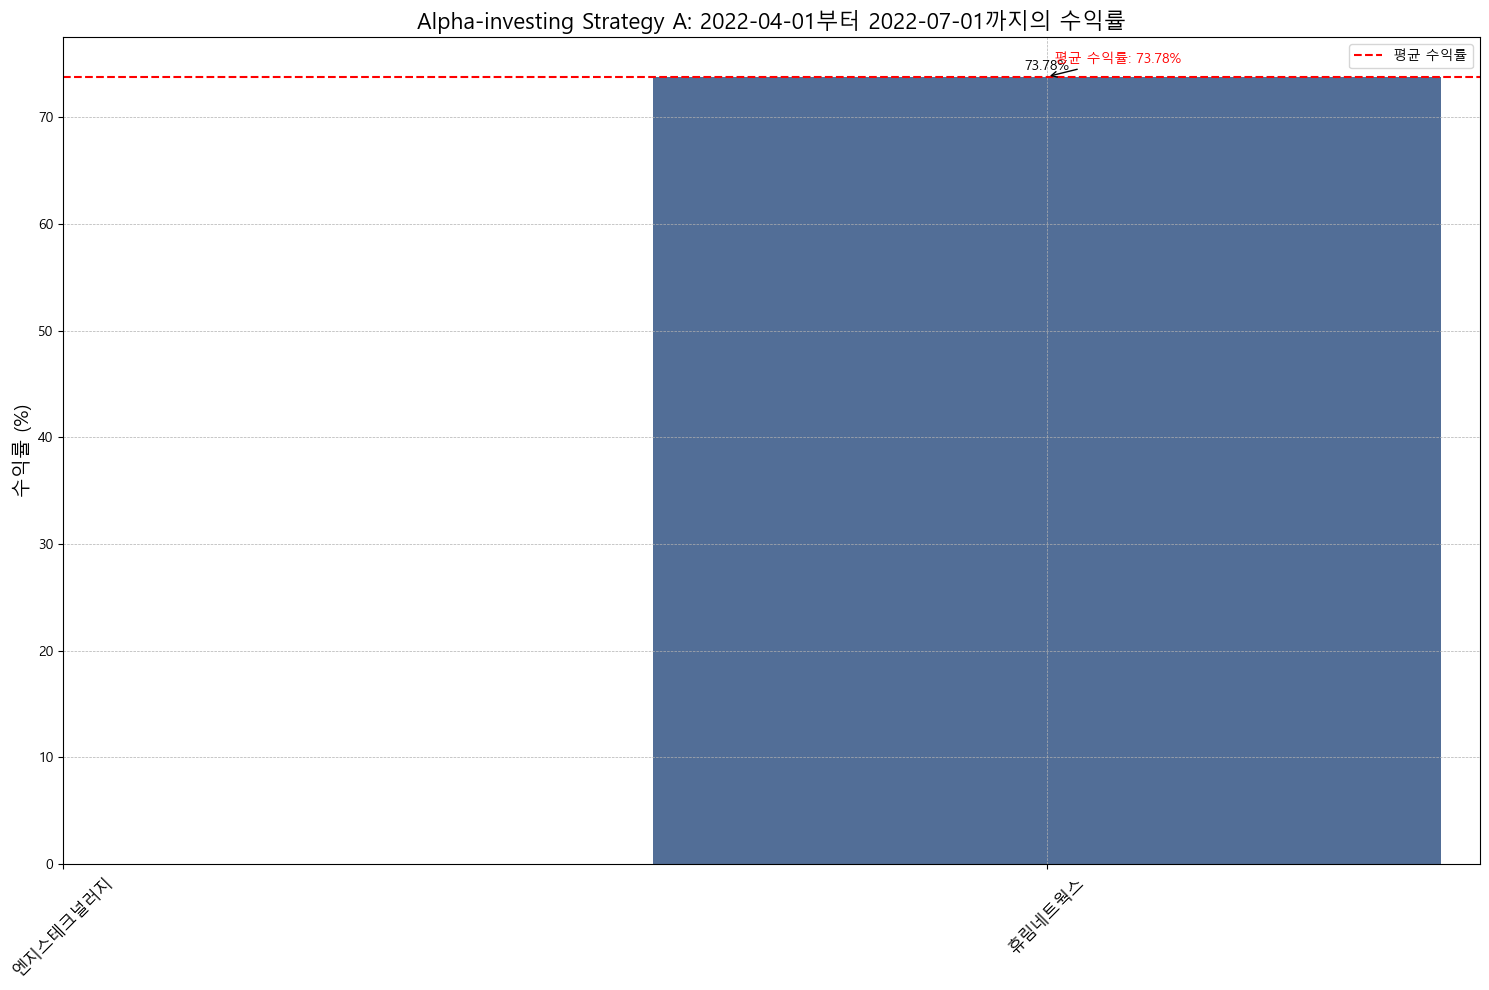

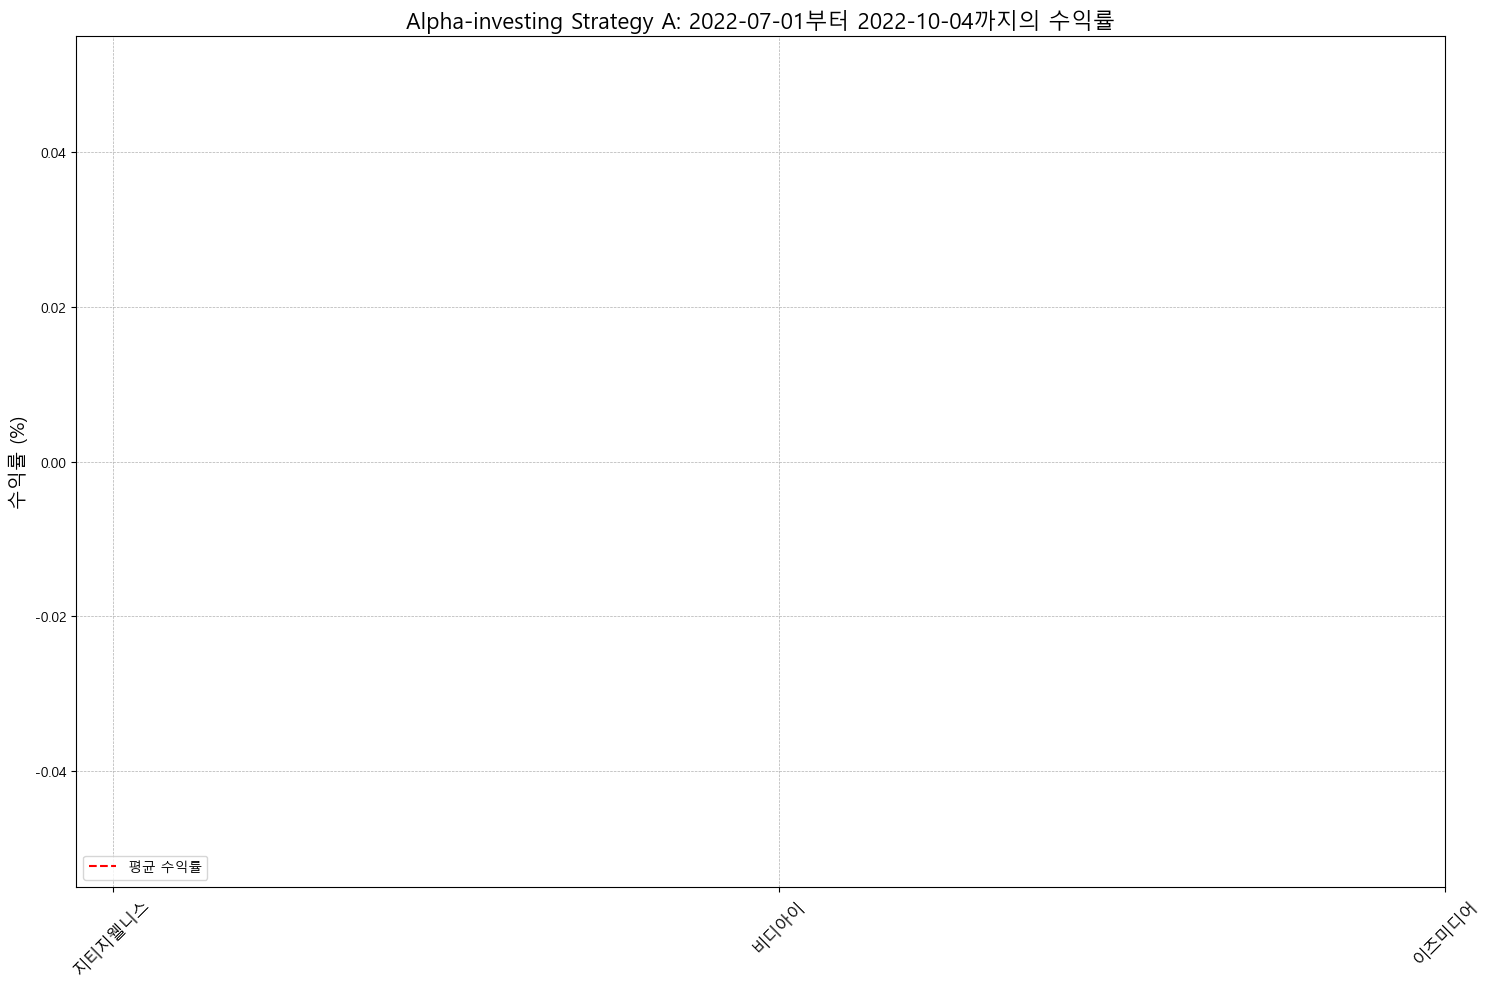

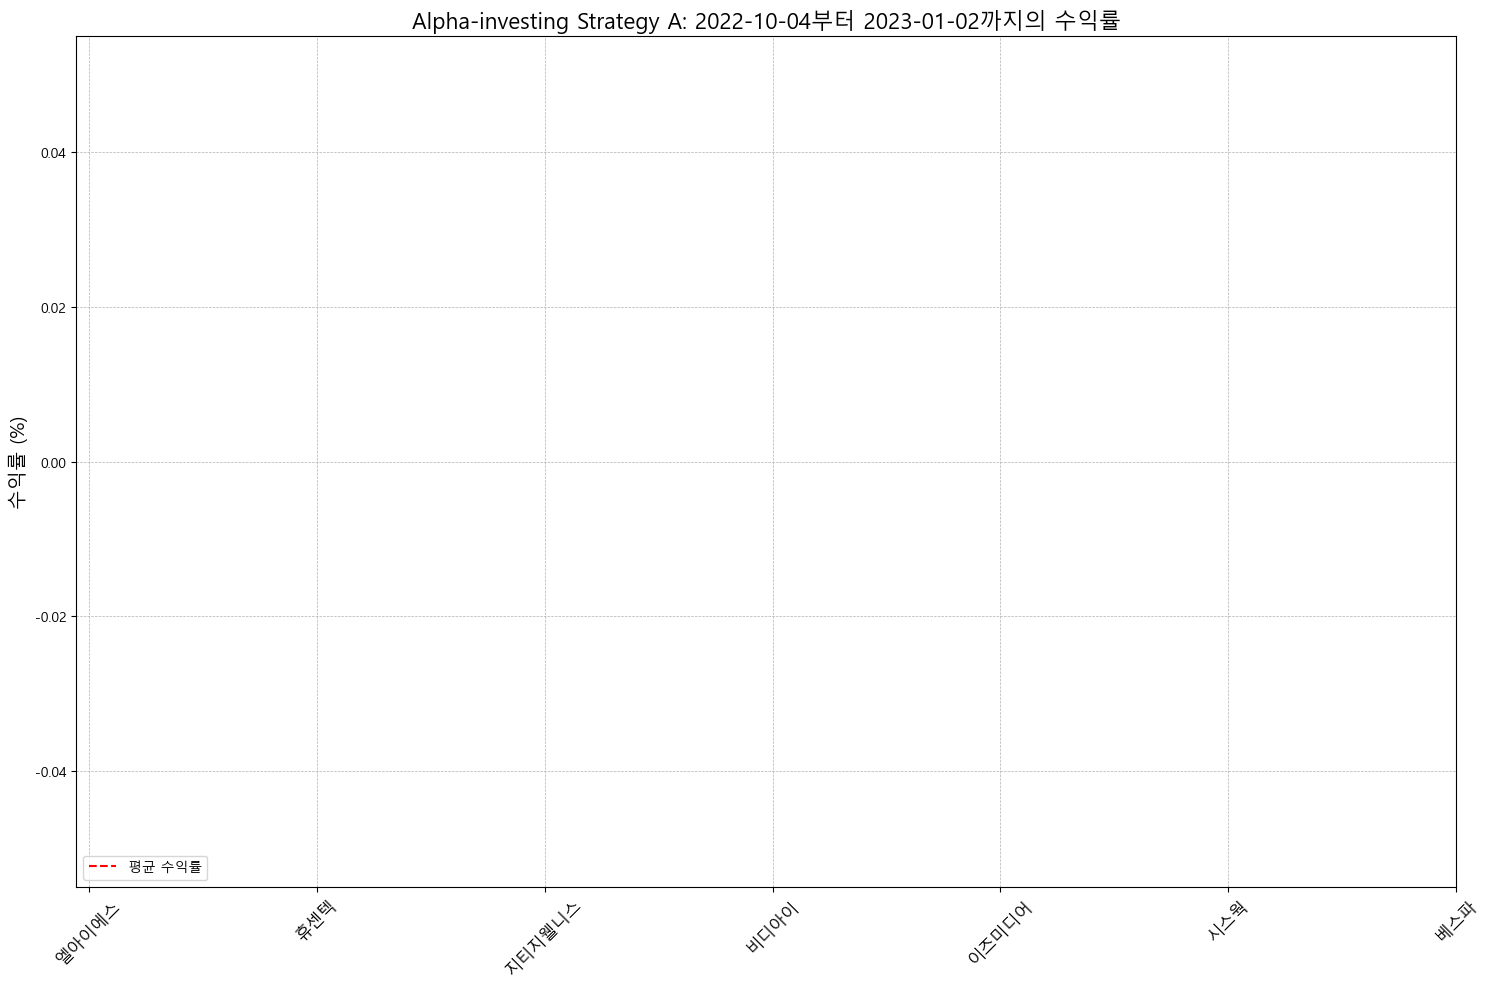

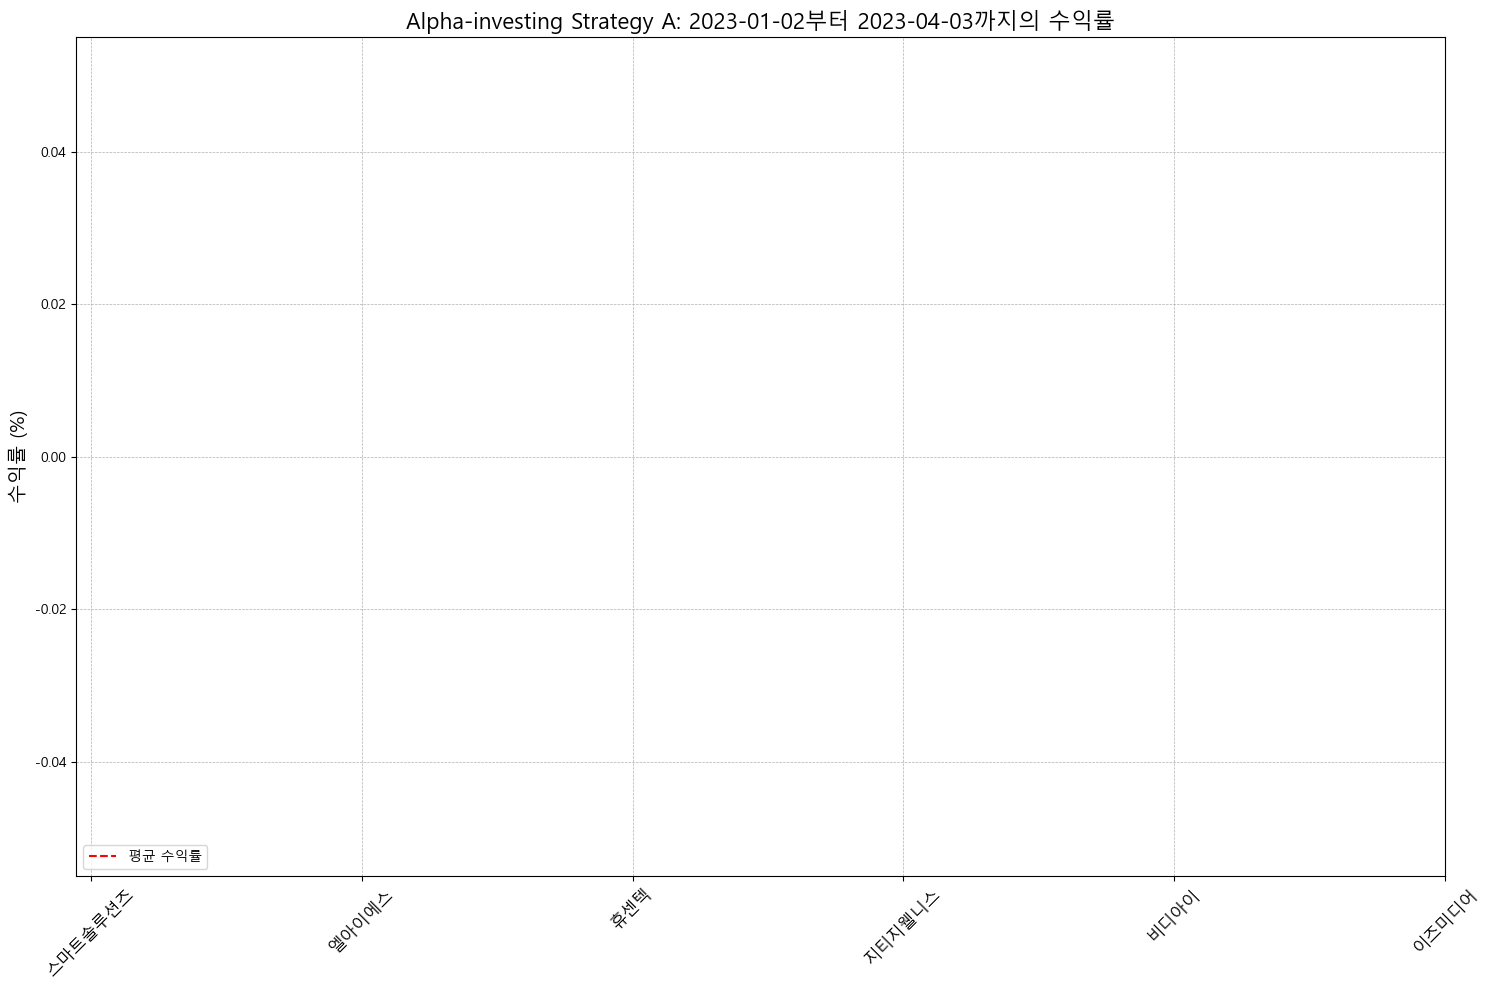

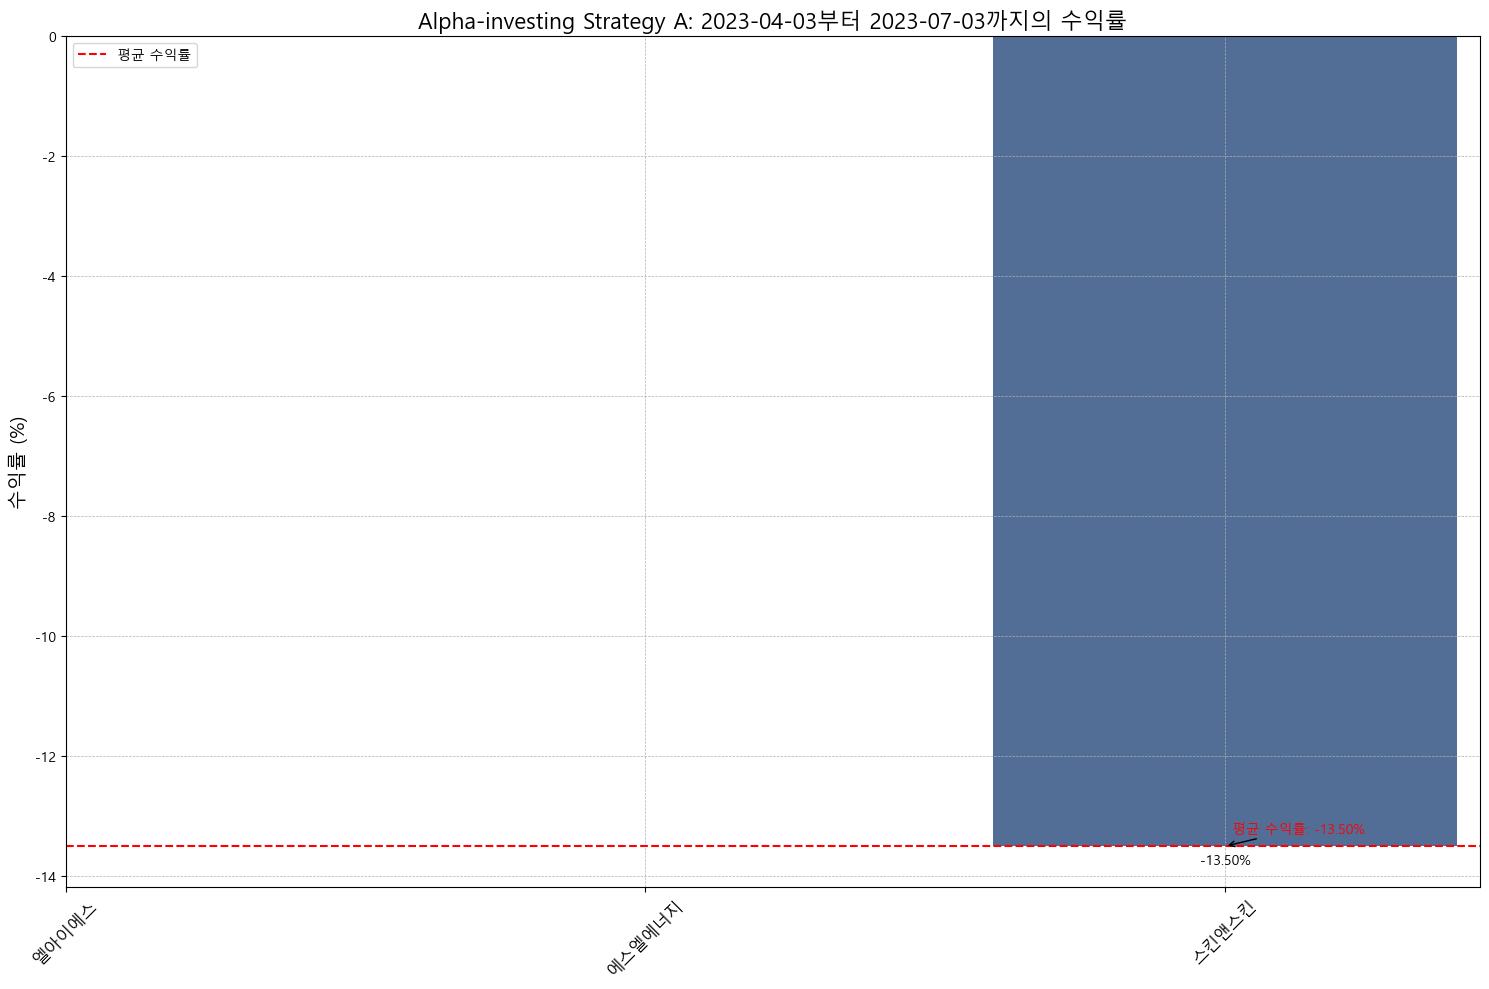

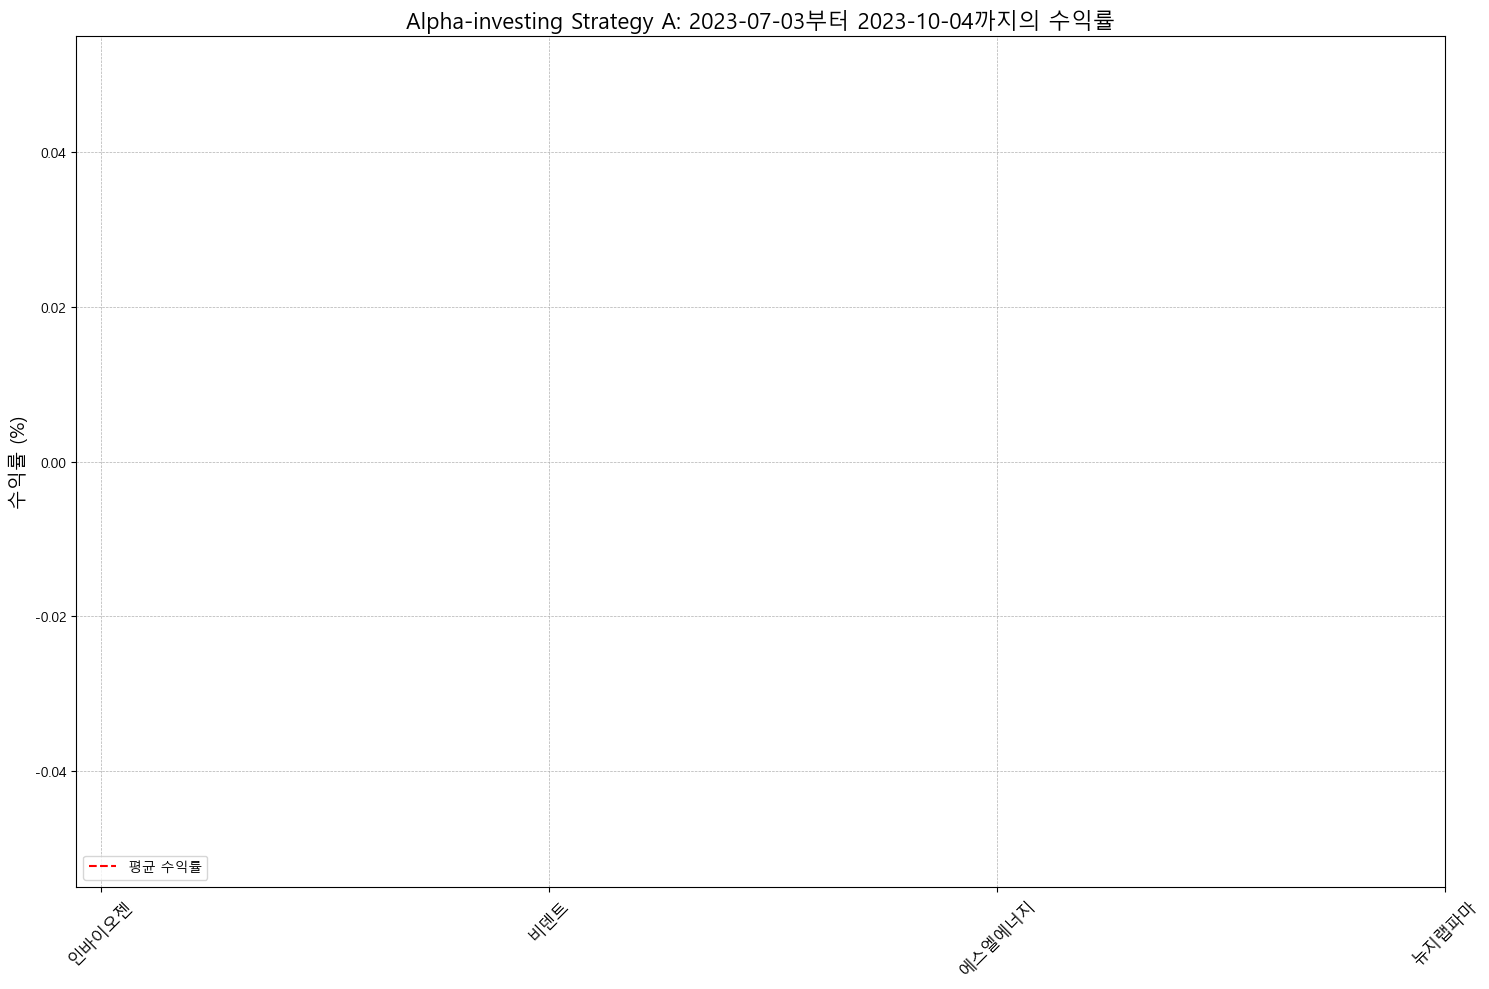

In [ ]:
# 실행은 되는 코드. 종목코드가 10개씩 나오지는 않음.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrx import stock

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
close_df = pd.read_csv('reshape_df.csv')  # 실제 사용시 주석을 제거하세요.

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

def format_stock_code(code):
    # 종목 코드를 6자리 포맷으로 변환하는 함수
    return str(code).zfill(6)

# 전략에 따른 종목 선정 함수
def select_stocks(close_df, rebalancing_dates):
    held_stocks_dict = {}
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df.loc[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        # 가격이 30% 이상 하락한 종목 찾기
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()

        # 해당 종목들의 변동성 계산
        volatility = period_df[dropped_stocks].iloc[-60:].std()

        # 변동성이 낮은 종목 10개 선정
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()

        # 포맷된 종목 코드 저장
        held_stocks_dict[date] = [format_stock_code(code) for code in selected_stocks]
    
    return held_stocks_dict

held_stocks_dict = select_stocks(close_df, rebalancing_dates)


# 종목 코드로부터 회사 이름 매핑
def get_company_names_from_pykrx(stock_codes):
    company_names_mapping = {}
    for code in stock_codes:
        try:
            company_name = stock.get_market_ticker_name(code)
            company_names_mapping[code] = company_name
        except:
            # 매핑 실패 시, 종목 코드 그대로 사용
            company_names_mapping[code] = code
    return company_names_mapping

stock_codes = list(set(code for sublist in held_stocks_dict.values() for code in sublist))
company_names_mapping = get_company_names_from_pykrx(stock_codes)

def plot_selected_stock_returns(start_date, end_date, selected_stocks, company_names_mapping):
    # 주어진 종목 코드의 수익률을 시각화하는 함수
    # 데이터프레임에서 해당 날짜 범위를 추출
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)]

    # 데이터에 존재하는 종목 코드만 필터링
    existing_stocks = [stock for stock in selected_stocks if stock in period_df.columns]

    # 필터링된 종목만으로 수익률 계산
    returns = (period_df[existing_stocks].iloc[-1] - period_df[existing_stocks].iloc[0]) / period_df[existing_stocks].iloc[0]
    average_return = returns.mean()

    # 시각화
    fig, ax = plt.subplots(figsize=(15, 10))
    # 매핑된 이름 또는 코드를 사용하여 회사명 리스트 생성
    company_names = [company_names_mapping.get(code, code) for code in existing_stocks]
    # ... 나머지 시각화 코드
    colors = plt.cm.Blues(np.linspace(0.5, 1, len(returns)))
    bars = ax.bar(company_names, returns.values * 100, color=colors, alpha=0.7)
    ax.axhline(average_return * 100, color='red', linestyle='--', linewidth=1.5, label='평균 수익률')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')
    ax.annotate(f'평균 수익률: {average_return * 100:.2f}%',
                xy=(len(company_names)-1, average_return * 100),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=10,
                color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.set_title(f'Alpha-investing Strategy A: {start_date}부터 {end_date}까지의 수익률', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(company_names)
    ax.set_xticklabels(company_names, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()




for date in rebalancing_dates[:-1]:
    next_date = rebalancing_dates[rebalancing_dates.index(date) + 1]
    selected_stocks = held_stocks_dict[date]
    plot_selected_stock_returns(date, next_date, selected_stocks, company_names_mapping)
